<a href="https://colab.research.google.com/github/marcvonrohr/machine_learning/blob/main/lab_8/lab_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="right" style="max-width: 200px; height: auto" src="https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_8/hsg_logo.png?raw=1">

##  Lab 08 - Autoencoder Neural Networks

Machine Learning, University of St. Gallen, 2025

In this lab, we will apply the **deep autoencoder neural networks** (AENNs) introduced in the lecture to detect anomalies in the accounting records of financial accounting. Unlike classical feedforward networks, AENNs learn to **encode** input data into a low-dimensional representation. At the same time, the AENN learns to **decode** the original data from the encoded representation.

The decoded data, commonly referred to as the **reconstruction**, should be very similar to the original **input data**. Therefore, accounting entries that can only be reconstructed with errors must exhibit one or more unusual characteristics. The following figure provides an overview of the deep learning process and the AENN network architecture, which we will implement in this lab.

<img align="center" style="max-width: 900px" src="https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_8/process.png?raw=1">

During the lab, we will again use some functions of the `PyTorch` library to implement and train the AENN. Throughout the training process, the AENN should learn the characteristic features of historical **bookings** or **journal entries**. After successful model training, we will apply the model to detect unusual journal entries within the dataset based on the reconstruction error. Finally, we will use the learned **representations** of the individual journal entries to interpret the obtained results even more meaningfully.

In case of any questions, please do not hesitate to contact us via **marco (dot) schreyer (at) unisg (dot) ch**. We wish you a lot of fun with our notebooks and your audit analyses!

## Learning Objectives of the Lab:

After today's exercise, you should be able to:

>1. Understand the **basic concepts, functionality, and components** of autoencoder neural networks.
>2. Perform **preprocessing** of categorical financial data (i.e., one-hot encoding and min-max normalization).
>3. Apply autoencoder neural networks to detect **anomalies** in extensive financial data.
>4. Interpret the results or **reconstruction error** of autoencoder neural networks.

## 1. Setting up the Analysis Environment

Similar to the previous exercises, we will first import a series of Python libraries that enable data analysis and visualization. In this exercise, we will use the libraries `PyTorch`, `Pandas`, `Numpy`, `Scikit-Learn`, `Matplotlib`, and `Seaborn`. Below, we import the required libraries by executing the following instructions:

In [59]:
# import python data science and utility libraries
import os, sys, itertools, urllib, io, warnings
import datetime as dt
import pandas as pd
import pandas_datareader as dr
import numpy as np

Import the `PyTorch` deep learning libraries:

In [60]:
# pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import dataloader

Import the `Matplotlib` and `Seaborn` visualization libraries and set the visualization parameters:

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi']= 150

Turn off possible warnings, e.g., due to future changes in the libraries:

In [62]:
# set the warning filter flag to ignore warnings
warnings.filterwarnings('ignore')

Activate the so-called inline display of visualizations in Jupyter Notebook:

In [63]:
%matplotlib inline

Create subdirectories within the current working directory for (1) saving the original data, (2) the analysis results, and (3) the trained models:

In [64]:
# create the data sub-directory
data_directory = './01_data'
if not os.path.exists(data_directory): os.makedirs(data_directory)

# create the results sub-directory
results_directory = './02_results'
if not os.path.exists(results_directory): os.makedirs(results_directory)

# create the models sub-directory
models_directory = './03_models'
if not os.path.exists(models_directory): os.makedirs(models_directory)

Setting a random seed to ensure reproducibility:

In [65]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value); # set pytorch seed cpu

Activating `GPU` computing by setting the device flag and setting a random `CUDA` seed:

In [66]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# set pytorch gpu seed
torch.cuda.manual_seed(seed_value)

# log type of device enabled
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] notebook with {} computation enabled'.format(str(now), str(device)))

[LOG 2025.05.12-20:16:00] notebook with cuda computation enabled


Displaying hardware information for the available GPU(s):

In [67]:
!nvidia-smi

Mon May 12 20:16:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P0             26W /   70W |     404MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Displaying software information for the available `Python` and `PyTorch` versions:

In [68]:
# print current Python version
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] The Python version: {}'.format(now, sys.version))

[LOG 2025.05.12-20:16:00] The Python version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]


In [69]:
# print current PyTorch version
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] The PyTorch version: {}'.format(now, torch.__version__))

[LOG 2025.05.12-20:16:00] The PyTorch version: 2.6.0+cu124


## 2. Data Acquisition and Data Preparation

Nowadays, companies are accelerating the digitization of business processes, which also impacts Enterprise Resource Planning (ERP) systems. These systems gather large amounts of granular data, particularly an organization's journal entries, which are recorded within the general ledger and respective subsidiary ledgers.

**Figure 1** presents a hierarchical view of an ERP system that captures journal entries in database tables. In the context of audit reviews, the data captured in these systems can contain traces or valuable clues pointing to potential fraudulent actions.

<img align="middle" style="max-width: 600px; height: auto" src="https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_8/accounting.png?raw=1">

**Figure 1:** Hierarchical view of an Enterprise Resource Planning (ERP) system capturing business transactions at various abstraction levels in database tables, i.e., at level (1) of the business process, (2) of accounting, and (3) of the database.

Initially, we will descriptively analyze the dataset used in the lab. Then, we will preprocess the data to create a baseline for training a neural network. The lab dataset is based on a modified subset of the **"Synthetic Financial Dataset For Fraud Detection"** dataset by Lopez-Rojas. The original dataset was initially published on the Kaggle platform for data science competitions and can be accessed via the following link: https://www.kaggle.com/ntnu-testimon/paysim1.

First, we load the dataset into our analysis environment:

In [70]:
# load the dataset into the notebook
url = 'https://raw.githubusercontent.com/HSG-AIML-Teaching/ML2025-Lab/main/lab_8/01_data/fraud_dataset_small.csv'
ori_dataset = pd.read_csv(url)

Next, we verify the dimensionality of the dataset:

In [71]:
# inspect the datasets dimensionalities
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] transactional dataset of {} rows and {} columns retreived.'.format(now, ori_dataset.shape[0], ori_dataset.shape[1]))

[LOG 2025.05.12-20:16:02] transactional dataset of 91247 rows and 10 columns retreived.


Additionally, we save a backup copy of the loaded dataset with the current timestamp:

In [72]:
# determine current timestamp
timestamp = dt.datetime.utcnow().strftime("%Y-%m-%d_%H-%M-%S")

# define dataset filename
filename = timestamp + " - original_fraud_dataset.xlsx"

# save dataset extract to the data directory
ori_dataset.head(100).to_excel(os.path.join(data_directory, filename)) # just saving the first 100 rows as a sample

### 2.1 Initial Data Assessment

The dataset contains a total of **seven categorical** and **two numerical attributes** corresponding to the tables BKPF (accounting document headers) and BSEG (accounting document segments) within an SAP FICO module. The list below provides an overview of the individual attributes, along with a brief description of their respective semantics:

>- `BELNR`: the accounting document number,
>- `BUKRS`: the company code,
>- `BSCHL`: the posting key,
>- `HKONT`: the posted general ledger account,
>- `PRCTR`: the posted profit center,
>- `WAERS`: the currency key,
>- `KTOSL`: the key of the general ledger account,
>- `DMBTR`: the amount in the local currency,
>- `WRBTR`: the amount in the document currency.

Let's also examine the first 10 rows of the dataset in detail:

In [73]:
# inspect top rows of dataset
ori_dataset.head(10)

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,456737,C2,C23,C1,C10,A1,B1,64962.21,0.00,regular
1,87791,C6,C61,C5,C53,A2,B1,522465.43,522465.43,regular
2,104539,C3,C30,C1,C17,A3,B1,903760.72,571.00,regular
3,73560,C1,C12,C9,C95,A1,B1,252628.54,0.00,regular
4,48480,C2,C20,C1,C11,A1,B1,1231440.06,20363.00,regular
5,270089,C7,C71,C1,C14,A3,B1,230323.36,0.00,regular
6,272714,C1,C10,C1,C16,A1,B1,373399.70,0.00,regular
7,160295,C1,C14,C2,C27,A1,B3,888555.15,194811.00,regular
8,233425,C1,C15,C4,C40,A1,B3,2004667.92,31473.00,regular
9,136973,C6,C65,C3,C34,A2,B2,958050.23,112519.00,regular


You might have noticed the attribute labeled `Label` in the data while reviewing it. This attribute contains the ground truth information for each individual journal entry. The attribute describes the 'true nature' of each transaction, i.e., whether it is a **regular** transaction (marked by `regular`) or a **anomaly** (marked by `global` and `local`).

In our approach, we will use the label information solely to validate the results of our trained models. However, please note that such a field often isn't available in real-life scenarios. Now let's examine the distribution of regular transactions versus anomalous transactions in the dataset:

In [74]:
# number of anomalies vs. regular transactions
ori_dataset.label.value_counts()

,count
label,
regular,91147
global,70
local,30


The analysis reveals that, similar to the real world, we are dealing with an **unbalanced** dataset. The dataset contains only a tiny proportion of **100 (0.109%)** anomalous transactions in total. Among the 100 anomalies, there are **70 (0.076%)** `global` anomalies and **30 (0.003%)** `local` anomalies.

In the next step, we remove the label attribute from the training dataset and store it in a separate variable:

In [75]:
# remove the "ground-truth" label information for the following steps of the class
label = ori_dataset.pop('label')

### 2.2 Preprocessing of Categorical Attributes

Upon examining the data, it's evident that the majority of attributes have categorical (discrete) attribute values, such as the journal entry date, the main ledger account, the journal entry type, and the currency. Let's take a closer look at the distribution of the categorical attributes *posting key* `BSCHL` and *general ledger account* `HKONT`:

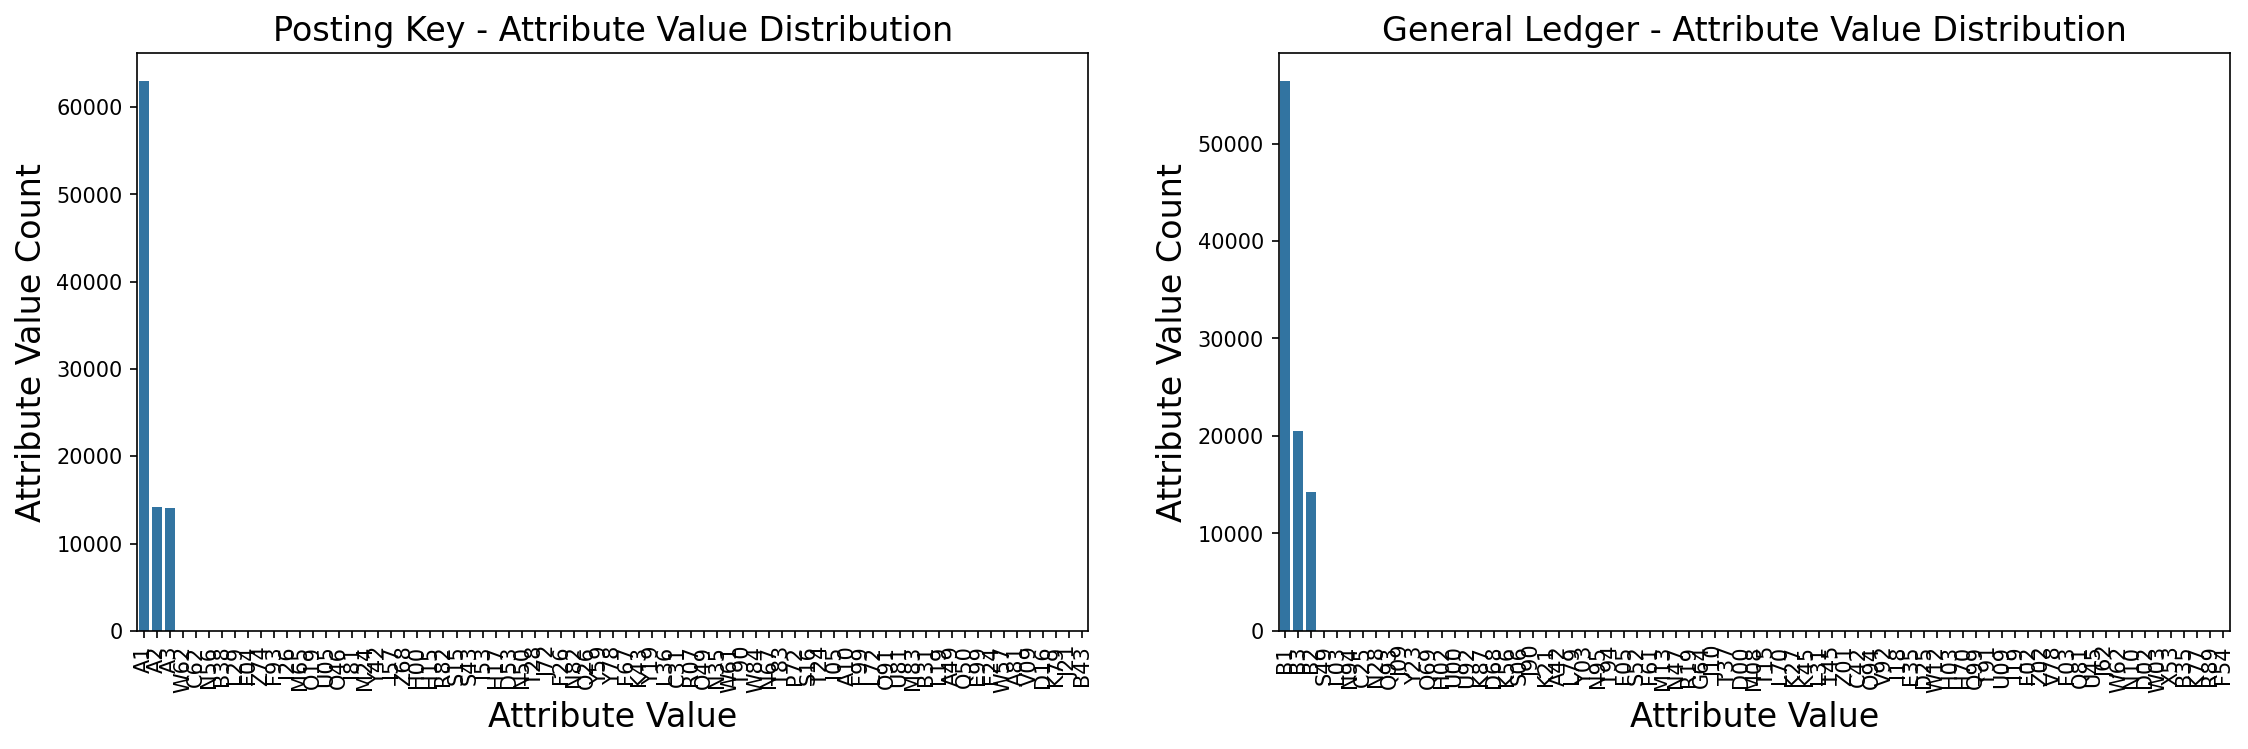

In [76]:
# prepare to plot posting key and general ledger account side by side
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(18)

# plot the distribution of the posting key attribute
plot = sns.countplot(x=ori_dataset['BSCHL'], ax=ax[0])

# set axis labels
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plot.set_xlabel('Attribute Value', fontsize=16)
plot.set_ylabel('Attribute Value Count', fontsize=16)

# set plot title
plot.set_title('Posting Key - Attribute Value Distribution', fontsize=16)

# plot the distribution of the general ledger attribute
plot = sns.countplot(x=ori_dataset['HKONT'], ax=ax[1])

# set axis labels
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plot.set_xlabel('Attribute Value', fontsize=16)
plot.set_ylabel('Attribute Value Count', fontsize=16)

# set plot title
plot.set_title('General Ledger - Attribute Value Distribution', fontsize=16);

In general, neural networks are designed to process numerical data. One way to meet this requirement is to apply a method known as **One-Hot Encoding**. This allows a numerical representation of categorical attribute values to be derived. With **One-Hot Encoding**, an additional binary column is created in the data for each categorical attribute value.

Consider the example in **Figure 2** below. The categorical attribute Receiver in the original data contains the names 'Sally', 'John', and 'Emma'. We encode the attribute as a 'one-hot' attribute by creating an additional binary column for each categorical value in the 'Receiver' column. Then, for example, we encode each transaction with the value 'Sally' in the 'Receiver' column with the value 1.0 within the 'Sally' column of the transaction. If a transaction has a different value in the 'Receiver' column, we encode the 'Sally' column with the value 0.0.

<img align="middle" style="max-width: 500px; height: auto" src="https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_8/encoding.png?raw=1">

**Figure 2:** Exemplary **One-Hot Encoding** of the different receiver attribute values into specific binary one-hot columns. Each observed attribute value in the dataset results in its own column. The column value **1.0** encodes the occurrence of the attribute value in the corresponding journal entry. The column value **0.0**, on the other hand, indicates that the attribute value does not occur within the corresponding journal entry.

Using this method, the six categorical attributes of the dataset can be converted into numerical attributes. The `Pandas` library offers the appropriate functionality, which we apply in the following:

In [77]:
# select categorical attributes to be "one-hot" encoded
categorical_attr_names = ['BUKRS', 'KTOSL', 'PRCTR', 'BSCHL', 'HKONT', 'WAERS']

# encode categorical attributes into a binary one-hot encoded representation
ori_dataset_cat_processed = pd.get_dummies(ori_dataset[categorical_attr_names], dtype=np.float32)

Afterward, we verify the performed **One-Hot Encoding** using the first 10 journal entries of the dataset:

In [78]:
# inspect encoded sample transactions
ori_dataset_cat_processed.head(10)

,BUKRS_A43,BUKRS_A89,BUKRS_B37,BUKRS_B76,BUKRS_C10,BUKRS_C11,BUKRS_C12,BUKRS_C13,BUKRS_C14,BUKRS_C15,...,WAERS_U72,WAERS_U94,WAERS_V89,WAERS_W25,WAERS_W59,WAERS_X26,WAERS_Y59,WAERS_Z06,WAERS_Z37,WAERS_Z54
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.3 Preprocessing of Numerical Attributes

Next, we analyze the distributions of the two numerical attributes of the dataset. These are the attributes (1) *Amount in local currency* `DMBTR` and (2) *Amount in document currency* `WRBTR`, the distributions of which we will visualize below:

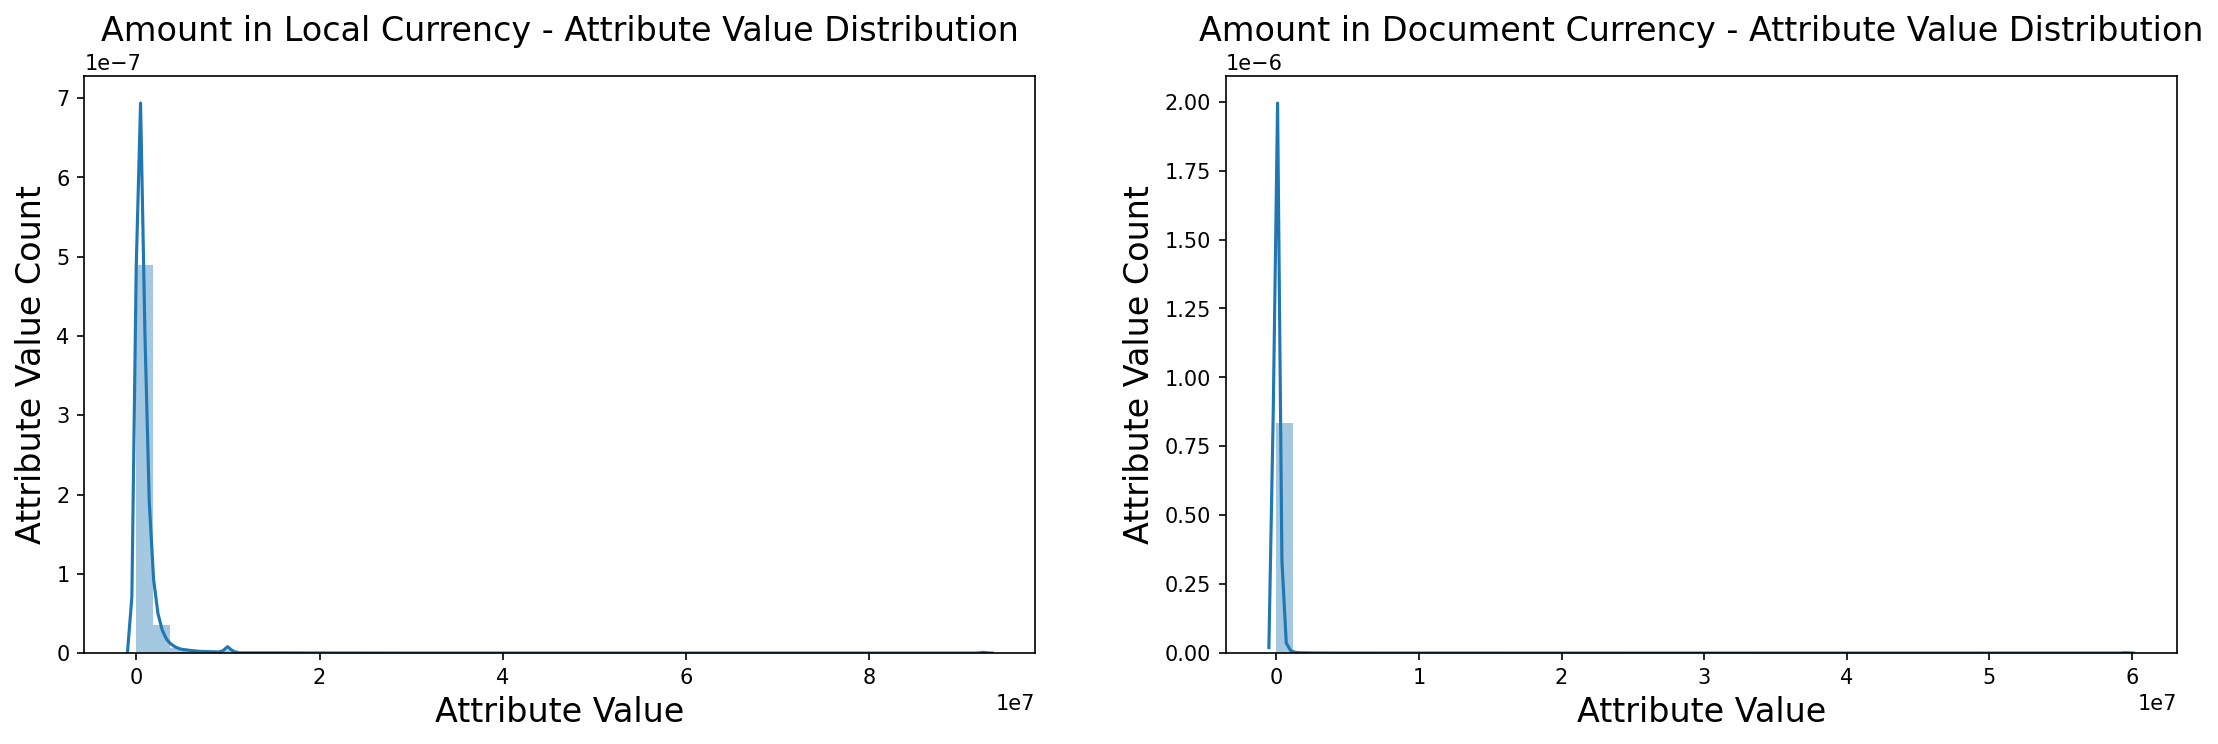

In [79]:
# plot the log-scaled 'DMBTR' as well as the 'WRBTR' attribute value distribution
fig, ax = plt.subplots(1,2)
fig.set_figwidth(18)

# plot distribution of the local amount attribute
plot = sns.distplot(ori_dataset['DMBTR'].tolist(), ax=ax[0])

# set axis labels
plot.set_xlabel('Attribute Value', fontsize=16)
plot.set_ylabel('Attribute Value Count', fontsize=16)

# set plot title
plot.set_title('Amount in Local Currency - Attribute Value Distribution', fontsize=16)

# plot distribution of the document amount attribute
plot = sns.distplot(ori_dataset['WRBTR'].tolist(), ax=ax[1])

# set axis labels
plot.set_xlabel('Attribute Value', fontsize=16)
plot.set_ylabel('Attribute Value Count', fontsize=16)

# set plot title
plot.set_title('Amount in Document Currency - Attribute Value Distribution', fontsize=16);

The values of both amount attributes exhibit a **skewed** and **steep distribution**. Therefore, we will first scale the values logarithmically. Subsequently, we will min-max normalize the scaled values:

In [80]:
# select the 'DMBTR' and 'WRBTR' attribute
numeric_attr_names = ['DMBTR', 'WRBTR']

# add a small epsilon to eliminate zero values from data for log scaling
numeric_attr = ori_dataset[numeric_attr_names] + 1e-7

# log scale the 'DMBTR' and 'WRBTR' attribute values
numeric_attr = numeric_attr.apply(np.log)

# normalize all numeric attributes to the range [0,1]
ori_dataset_num_processed = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())

In the next step, we visualize the distributions of the scaled and normalized values for both amount attributes:

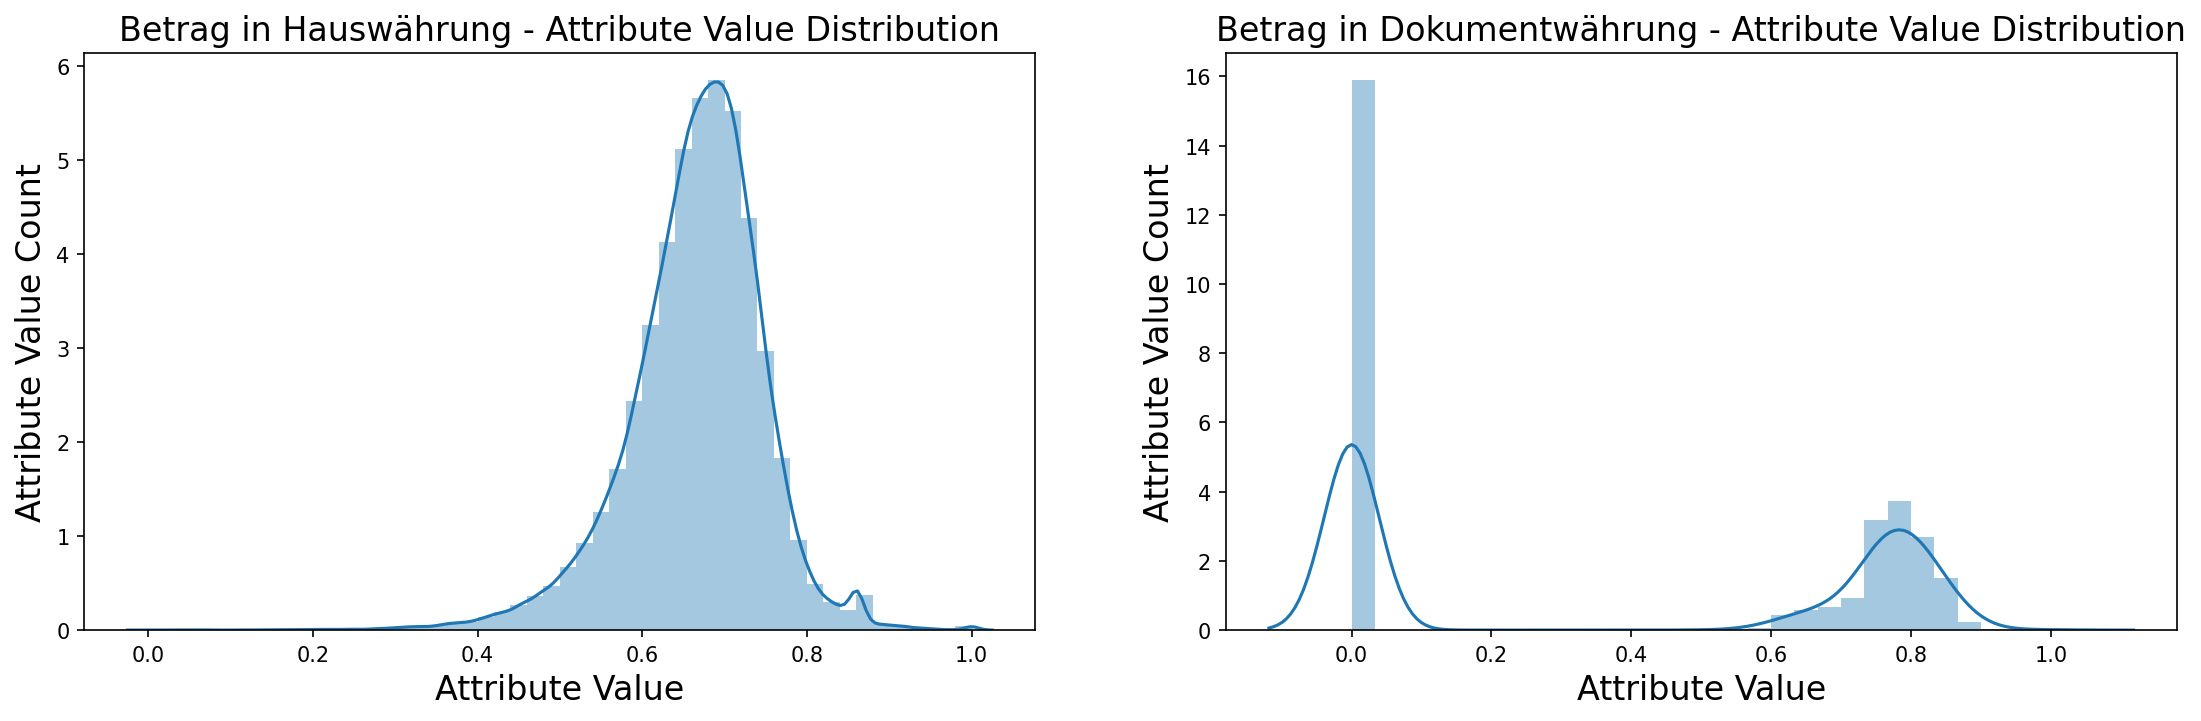

In [81]:
# plot the log-scaled 'DMBTR' as well as the 'WRBTR' attribute value distribution
fig, ax = plt.subplots(1,2)
fig.set_figwidth(18)

# plot distribution of the local amount attribute
plot = sns.distplot(ori_dataset_num_processed['DMBTR'].tolist(), ax=ax[0])

# set axis labels
plot.set_xlabel('Attribute Value', fontsize=16)
plot.set_ylabel('Attribute Value Count', fontsize=16)

# set plot title
plot.set_title('Betrag in Hauswährung - Attribute Value Distribution', fontsize=16)

# plot distribution of the document amount attribute
plot = sns.distplot(ori_dataset_num_processed['WRBTR'].tolist(), ax=ax[1])

# set axis labels
plot.set_xlabel('Attribute Value', fontsize=16)
plot.set_ylabel('Attribute Value Count', fontsize=16)

# set plot title
plot.set_title('Betrag in Dokumentwährung - Attribute Value Distribution', fontsize=16);

### 2.4 Merging Categorical and Numerical Transaction Attributes

Finally, we merge the preprocessed numerical and categorical attributes into a **single dataset**. The merged dataset will serve as the foundation for the subsequent training of the Autoencoder Neural Network (AENN):

In [82]:
# merge categorical and numeric subsets
ori_subset_transformed = pd.concat([ori_dataset_cat_processed, ori_dataset_num_processed], axis = 1)

Now, let's take a final look at the dimensionality of the merged dataset:

In [83]:
# inspect final dimensions of pre-processed transactional data
ori_subset_transformed.shape

(91247, 618)

After completing the preprocessing steps, we have a dataset consisting of a total of **91,147 records (rows)** and **618 attributes (columns)**. We should keep the number of columns in mind, as it will determine the dimensionality of the input and output layers of our AENN.

## 3. Autoencoder Neural Network Implementierung

In diesem Abschnitt möchten wir uns mit der zugrundeliegenden Idee und dem Aufbau eines tiefen **Autoencoder Neural Networks (AENN)** vertraut zu machen. Hierzu werden wir die einzelne Bausteine und die spezifische Netzwerkstruktur von AENNs anhand der `PyTorch` Open-Source-Bibliothek implementieren.

### 3.1 Autoencoder Neural Network Architecture

*Autoencoder Neural Networks*, also referred to as *Replicator Neural Networks*, are an unsupervised learning variant of classic feed-forward networks. This particular architecture was originally developed by Geoffrey Hinton and Ruslan Salakhutdinov. AENNs typically consist of a **symmetrical** network architecture and a central hidden layer, referred to as the **latent** or **bottleneck** layer. This layer has a lower dimensionality than the input and output layers of the network. The learning objective of the AENN is to reconstruct the original input data as accurately as possible at the output layer of the network. **Figure 3** shows a schematic representation of an Autoencoder Neural Network:

<img align="middle" style="max-width: 800px; height: auto" src="https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_8/autoencoder.png?raw=1">

**Figure 3:** Schematic representation of an **Autoencoder Neural Network**, which consists of two non-linear mappings or feed-forward networks. The two interconnected networks are referred to as the **Encoder** $f_\theta: \mathbb{R}^{dx} \mapsto \mathbb{R}^{dz}$ and **Decoder** $g_\theta: \mathbb{R}^{dz} \mapsto \mathbb{R}^{dx}$.

In general, AENNs can be interpreted as 'lossy' **compression algorithms**. They are 'lossy' in the sense that the reconstructed outputs may have errors compared to the original inputs. The difference between the original input $x^i$ and its **reconstruction** $\hat{x}^i$ is also referred to as the reconstruction error. In general, AENNs consist of three main components:

> 1. an Encoder $f_\theta$,
> 2. a Decoder $g_\theta$,
> 3. an error function $\mathcal{L_{\theta}}$.

The encoder and decoder each consist of a classic feedforward network with learnable parameters $\theta$. The **encoder** $f_\theta(\cdot)$ maps an input vector (e.g., a journal entry) $x^i$ onto a compressed (i.e., low-dimensional) representation $z^i$ in the so-called latent space $Z$. The low-dimensional representation $z^i$ is then mapped by the **decoder** $g_\theta(\cdot)$ onto an output vector $\hat{x}^i$ of the original input space (e.g., the reconstructed journal entry) is mapped. Formally, the two networks can also be interpreted as non-linear mappings or functions:

<center>$f_\theta(x^i) = s(Wx^i + b)$ &emsp; $f_\theta: \mathbb{R}^{dx} \mapsto \mathbb{R}^{dz}$,</center>
<center>$g_\theta(z^i) = s′(W′z^i + d)$ &emsp; $g_\theta: \mathbb{R}^{dz} \mapsto \mathbb{R}^{dx}$,</center>

where the two functions have the learnable model parameters $\theta = {W, b, W', d}$. The parameters $W \in \mathbb{R}^{d_x \times d_z}, W' \in \mathbb{R}^{d_z \times d_y}$ denote the weight matrices, the parameters $b \in \mathbb{R}^{dx}$, $d \in \mathbb{R}^{dz}$ the bias vectors of the networks, and $s$ and $s′$ the respective non-linear activation functions.

### 3.2 Autoencoder Neural Network Implementation

In the next step, we want to implement the Encoder Network in `PyTorch`. The encoder should consist of a total of **nine layers** of fully-connected neurons. In addition, the encoder should contain the following number of neurons per layer: 618-256-128-64-32-16-8-4-3. The previous notation means that the first layer comprises 618 neurons (determined by the dimensionality of the input data), the second layer 256 neurons, and the other layers 128, 64, 32, 16, 8, 4, and 3 neurons, respectively.

<img align="middle" style="max-width: 900px; height: auto" src="https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_8/neurons.png?raw=1">

The following three elements of the encoder implementation deserve special attention:

>- `self.encoder_Lx`: defines the linear transformation of the respective layer applied to the input: $Wx + b$.
>- `nn.init.xavier_uniform`: initializes weight parameters based on a uniform Xavier distribution.
>- `self.encoder_Rx`: defines the non-linear transformation of the respective layer applied to the input: $\sigma(\cdot)$.

We use so-called **Leaky ReLUs** to avoid saturating neurons and to accelerate training convergence. The application of Leaky ReLUs allows the calculation of gradients even within the negative range of an activation function (see figure above).

In [84]:
# implementation of the encoder network
class encoder(nn.Module):

    # define class constructor
    def __init__(self):

        # call super class constructor
        super(encoder, self).__init__()

        # specify layer 1 - in 618, out 512
        self.encoder_L1 = nn.Linear(in_features=ori_subset_transformed.shape[1], out_features=512, bias=True) # add linearity
        nn.init.xavier_uniform_(self.encoder_L1.weight) # init weights
        self.encoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity

        # specify layer 2 - in 512, out 256
        self.encoder_L2 = nn.Linear(512, 256, bias=True)
        nn.init.xavier_uniform_(self.encoder_L2.weight)
        self.encoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 256, out 128
        self.encoder_L3 = nn.Linear(256, 128, bias=True)
        nn.init.xavier_uniform_(self.encoder_L3.weight)
        self.encoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 4 - in 128, out 64
        self.encoder_L4 = nn.Linear(128, 64, bias=True)
        nn.init.xavier_uniform_(self.encoder_L4.weight)
        self.encoder_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 5 - in 64, out 32
        self.encoder_L5 = nn.Linear(64, 32, bias=True)
        nn.init.xavier_uniform_(self.encoder_L5.weight)
        self.encoder_R5 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 6 - in 32, out 16
        self.encoder_L6 = nn.Linear(32, 16, bias=True)
        nn.init.xavier_uniform_(self.encoder_L6.weight)
        self.encoder_R6 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 7 - in 16, out 8
        self.encoder_L7 = nn.Linear(16, 8, bias=True)
        nn.init.xavier_uniform_(self.encoder_L7.weight)
        self.encoder_R7 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 8 - in 8, out 4
        self.encoder_L8 = nn.Linear(8, 4, bias=True)
        nn.init.xavier_uniform_(self.encoder_L8.weight)
        self.encoder_R8 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 9 - in 4, out 3
        self.encoder_L9 = nn.Linear(4, 3, bias=True)
        nn.init.xavier_uniform_(self.encoder_L9.weight)
        self.encoder_R9 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

    # define forward pass
    def forward(self, x):

        # define forward pass through the network
        x = self.encoder_R1(self.encoder_L1(x))
        x = self.encoder_R2(self.encoder_L2(x))
        x = self.encoder_R3(self.encoder_L3(x))
        x = self.encoder_R4(self.encoder_L4(x))
        x = self.encoder_R5(self.encoder_L5(x))
        x = self.encoder_R6(self.encoder_L6(x))
        x = self.encoder_R7(self.encoder_L7(x))
        x = self.encoder_R8(self.encoder_L8(x))
        x = self.encoder_R9(self.encoder_L9(x))

        return x

Next, we instantiate a model of the encoder network:

In [85]:
# intstantiate the encoder network model
encoder_train = encoder()

Subsequently, we transfer the Encoder model to the `CPU` or a potentially available `GPU`:

In [86]:
# push model to compute device
encoder_train = encoder_train.to(device)

If available, we check whether the model has been successfully transferred to the `GPU`:

In [87]:
!nvidia-smi

Mon May 12 20:16:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P0             26W /   70W |     404MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Now we can visualize the model structure and review the network architecture once more by executing the following cell:

In [88]:
# print the initialized architectures
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] encoder architecture:\n\n{}\n'.format(now, encoder_train))

[LOG 2025.05.12-20:16:06] encoder architecture:

encoder(
  (encoder_L1): Linear(in_features=618, out_features=512, bias=True)
  (encoder_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L2): Linear(in_features=512, out_features=256, bias=True)
  (encoder_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L3): Linear(in_features=256, out_features=128, bias=True)
  (encoder_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L4): Linear(in_features=128, out_features=64, bias=True)
  (encoder_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L5): Linear(in_features=64, out_features=32, bias=True)
  (encoder_R5): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L6): Linear(in_features=32, out_features=16, bias=True)
  (encoder_R6): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L7): Linear(in_features=16, out_features=8, bias=True)
  (encoder_R7): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L8): Linear(in_features=8, out_featu

Next, we will complete the autoencoder architecture by implementing the corresponding decoder network. The decoder should also consist of a total of **nine layers** of fully-connected neurons. Additionally, the decoder should **symmetrically mirror** the architecture of the encoder. To accomplish this, we will invert the design of the encoder's layers layer-by-layer, following the structure 3-4-8-16-32-64-128-256, during the implementation of the decoder:

In [89]:
# implementation of the decoder network
class decoder(nn.Module):

    # define class constructor
    def __init__(self):

        # call super class constructor
        super(decoder, self).__init__()

        # specify layer 1 - in 3, out 4
        self.decoder_L1 = nn.Linear(in_features=3, out_features=4, bias=True) # add linearity
        nn.init.xavier_uniform_(self.decoder_L1.weight)  # init weights
        self.decoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity

        # specify layer 2 - in 4, out 8
        self.decoder_L2 = nn.Linear(4, 8, bias=True)
        nn.init.xavier_uniform_(self.decoder_L2.weight)
        self.decoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 8, out 16
        self.decoder_L3 = nn.Linear(8, 16, bias=True)
        nn.init.xavier_uniform_(self.decoder_L3.weight)
        self.decoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 4 - in 16, out 32
        self.decoder_L4 = nn.Linear(16, 32, bias=True)
        nn.init.xavier_uniform_(self.decoder_L4.weight)
        self.decoder_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 5 - in 32, out 64
        self.decoder_L5 = nn.Linear(32, 64, bias=True)
        nn.init.xavier_uniform_(self.decoder_L5.weight)
        self.decoder_R5 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 6 - in 64, out 128
        self.decoder_L6 = nn.Linear(64, 128, bias=True)
        nn.init.xavier_uniform_(self.decoder_L6.weight)
        self.decoder_R6 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 7 - in 128, out 256
        self.decoder_L7 = nn.Linear(128, 256, bias=True)
        nn.init.xavier_uniform_(self.decoder_L7.weight)
        self.decoder_R7 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 8 - in 256, out 512
        self.decoder_L8 = nn.Linear(256, 512, bias=True)
        nn.init.xavier_uniform_(self.decoder_L8.weight)
        self.decoder_R8 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 9 - in 512, out 618
        self.decoder_L9 = nn.Linear(in_features=512, out_features=ori_subset_transformed.shape[1], bias=True)
        nn.init.xavier_uniform_(self.decoder_L9.weight)
        self.decoder_R9 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

    # define forward pass
    def forward(self, x):

        # define forward pass through the network
        x = self.decoder_R1(self.decoder_L1(x))
        x = self.decoder_R2(self.decoder_L2(x))
        x = self.decoder_R3(self.decoder_L3(x))
        x = self.decoder_R4(self.decoder_L4(x))
        x = self.decoder_R5(self.decoder_L5(x))
        x = self.decoder_R6(self.decoder_L6(x))
        x = self.decoder_R7(self.decoder_L7(x))
        x = self.decoder_R8(self.decoder_L8(x))
        x = self.decoder_R9(self.decoder_L9(x)) # don't apply dropout to the AE output

        return x

Now, we will instantiate the decoder model for `CPU` or `GPU` training and ensure that the model has been successfully initialized. To do this, we will visualize the network architecture by executing the following cell:

In [90]:
# intstantiate the decoder network model
decoder_train = decoder()

# push model to compute device
decoder_train = decoder_train.to(device)

# print the initialized architectures
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] decoder architecture:\n\n{}\n'.format(now, decoder_train))

[LOG 2025.05.12-20:16:06] decoder architecture:

decoder(
  (decoder_L1): Linear(in_features=3, out_features=4, bias=True)
  (decoder_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L2): Linear(in_features=4, out_features=8, bias=True)
  (decoder_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L3): Linear(in_features=8, out_features=16, bias=True)
  (decoder_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L4): Linear(in_features=16, out_features=32, bias=True)
  (decoder_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L5): Linear(in_features=32, out_features=64, bias=True)
  (decoder_R5): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L6): Linear(in_features=64, out_features=128, bias=True)
  (decoder_R6): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L7): Linear(in_features=128, out_features=256, bias=True)
  (decoder_R7): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L8): Linear(in_features=256, out_features=51

Lastly, let's take a look at the number of model parameters we intend to train:

In [91]:
# init the number of encoder model parameters
encoder_num_params = 0

# iterate over the distinct encoder parameters
for param in encoder_train.parameters():

    # collect number of parameters
    encoder_num_params += param.numel()

# init the number of decoder model parameters
decoder_num_params = 0

# iterate over the distinct decoder parameters
for param in decoder_train.parameters():

    # collect number of parameters
    decoder_num_params += param.numel()

# print the number of model paramters
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] number of to be trained AENN model parameters: {}.'.format(now, encoder_num_params + decoder_num_params))

[LOG 2025.05.12-20:16:06] number of to be trained AENN model parameters: 985021.


Okay, our AENN model comprises a considerable total of **985,021** model parameters to be trained.

### 3.3 Autoencoder Neural Network Parameter Optimization

After successfully instantiating the AENN model, we now want to train the model. However, before we start training, it is necessary to define a suitable error function. As a reminder: We want to train our model in such a way that it learns a set of encoder and decoder parameters $θ$ that maximizes the similarity between a given journal entry $x^{i}$ and its reconstruction $\hat{x}^{i} = g_θ(f_θ(x^{i}))$.

Formally expressed, our training objective is to learn parameters $θ^*$ such that $\arg\min_{\theta} |X - g_\theta(f_\theta(X))|$. To achieve this optimization goal, we want to continuously minimize the error function or a so-called **reconstruction error** $\mathcal{L_{\theta}}$ as training progresses. A suitable error function for this purpose is the so-called **Binary Cross-Entropy (BCE)** reconstruction error, which is formally defined as follows:

<center> $\mathcal{L^{BCE}_{\theta}}(x^{i};\hat{x}^{i}) = \frac{1}{n}\sum_{i=1}^{n}\sum_{j=1}^{k} x^{i}_{j} ln(\hat{x}^{i}_{j}) + (1-x^{i}_{j}) ln(1-\hat{x}^{i}_{j})$, </center>

where $x^{i}$, $i=1,...,n$ denotes the set of journal entries, $\hat{x}^{i}$ the respective reconstructions, and $j=1,...,k$ indexes the various journal entry attributes. In the following, we instantiate the corresponding BCE error function from the `PyTorch` library:

In [92]:
# define the optimization criterion / loss function
loss_function = nn.BCEWithLogitsLoss()

Next, we transfer the computation of the error function to the `CPU` or an available `GPU` if applicable:

In [93]:
# push the optimization criterion / loss function to compute device
loss_function = loss_function.to(device)

Based on the error magnitude of a mini-batch of journal entries, the `PyTorch` library automatically calculates the gradients. Subsequently, the AENN parameters $θ$ are optimized based on the determined gradients. To achieve this, it is only necessary to define the desired optimization method in `PyTorch`. In the following notebook cell, we use the so-called **Adam Optimization** method for optimizing the model parameters $θ$. Additionally, we define a learning rate $l = 0.0001$:

In [94]:
# set the learning rate
learning_rate = 1e-4

#set the paramete optimization strategy of both networks
encoder_optimizer = torch.optim.Adam(encoder_train.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.Adam(decoder_train.parameters(), lr=learning_rate)

After successfully implementing and instantiating the three building blocks of the AENN model, let's take the time to review the definitions of the **Encoder** and **Decoder** models as well as the **BCE Reconstruction Error** and discuss any questions.

## 4. Autoencoder Neural Network Training

In this section, we aim to train an AENN model using the encoded transaction data. Moreover, we will take a detailed look at the individual training hyperparameters, training steps, and the training progress over time.

### 4.1 Definition der Hyperparameter

Let's begin by training an AENN model for **5 training epochs** and **128 journal entries** per mini-batch. This configuration of hyperparameters means that the dataset is fed to the AENN a total of five times in mini-batches of 128 bookings each. As a result, each training epoch will have **713 updates** (91,247 bookings modulo 128 bookings per mini-batch) of the AENN model parameters.

In [95]:
# specify training parameters
num_epochs = 5 # number of training epochs
mini_batch_size = 128 # size of the mini-batches

During the training phase, the AENN model should continuously receive mini-batches of the entire population of journal entries. For this purpose, we use the `DataLoader` functionality of the`PyTorch` library. These are iterators that continuously provide the bookings in the form of mini-batches. In the following cell, we instantiate a `PyTorch DataLoader` of the journal entry data:

In [96]:
# convert pre-processed transactional data to PyTorch tensor
torch_dataset = torch.from_numpy(ori_subset_transformed.values).float()

# push pre-processed transactional data to compute device
torch_dataset = torch_dataset.to(device)

# init training dataloader
train_dataloader = dataloader.DataLoader(torch_dataset, batch_size=mini_batch_size, shuffle=True)

(Note: By setting the parameter `shuffle`, the distinct mini-batches contain random journal entries of the datasets provided in a different order for each epoch.)

### 4.2 Training des Models

After defining the hyperparameters, we can start training the model. For each supplied mini-batch, the following steps are performed during the training process:

>1. Perform the forward pass through the encoder and decoder network.
>2. Calculate the BCE reconstruction error $\mathcal{L^{BCE}_{\theta}}(x^{i};\hat{x}^{i})$.
>3. Perform the backward pass through the decoder and encoder network.
>4. Update the encoder $f_\theta(\cdot)$ and decoder $g_\theta(\cdot)$ parameters.

To ensure learning during training, we monitor the BCE reconstruction error of the AENN model as the training progresses. By observing this, it is possible to infer the model's learning progress. Additionally, we can determine if and when the reconstruction error converges.

During the model optimization, we want to pay special attention to the following `PyTorch` instructions:

>- `reconstruction_loss.backward()`: Calculates the gradients based on the reconstruction error.
>- `encoder_optimizer.step()` and `decoder_optimizer.step()`: Update the parameters based on the gradients `encoder_optimizer.step()` and `decoder_optimizer.step()`: Update the parameters based on the gradients`.

After each completed training epoch, we also want to save a so-called **model checkpoint**. Checkpoints contain a snapshot of the model parameters at that point in time. In general, it is a good practice to save such checkpoints at regular intervals during training. If the training is interrupted, it can be resumed from the last checkpoint. To save a model checkpoint, we use the following `PyTorch` instruction:

>- `torch.save()`: Saves the checkpoint of the current model parameter values to the local file system.

In [97]:
# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode (apply dropout when needed)
encoder_train.train()
decoder_train.train()

# init the best loss by setting it to infinity
best_loss = np.inf

# train autoencoder model
for epoch in range(num_epochs):

    # init collection of epoch losses
    train_mini_batch_losses = []

    # init mini batch counter
    mini_batch_count = 0

    # iterate over all mini-batches
    for mini_batch_data in train_dataloader:

        # increase mini batch counter
        mini_batch_count += 1

        # push mini batch data to compute device
        mini_batch_data = mini_batch_data.to(device)

        # =================== (1) forward pass ===================================

        # run forward pass
        z_representation = encoder_train(mini_batch_data) # encode mini-batch data
        mini_batch_reconstruction = decoder_train(z_representation) # decode mini-batch data

        # =================== (2) compute reconstruction loss ====================

        # determine reconstruction loss
        reconstruction_loss = loss_function(mini_batch_reconstruction, mini_batch_data)

        # =================== (3) backward pass ==================================

        # reset graph gradients
        decoder_optimizer.zero_grad()
        encoder_optimizer.zero_grad()

        # run backward pass
        reconstruction_loss.backward()

        # =================== (4) update model parameters ========================

        # update network parameters
        decoder_optimizer.step()
        encoder_optimizer.step()

        # =================== monitor training progress ==========================

        # print training progress each 1.000 mini-batches
        if mini_batch_count % 1000 == 0:

            # print mini batch reconstuction results
            now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
            print('[LOG {}] epoch: [{}/{}], batch: {}, batch-train-loss: {}'.format(str(now), str(epoch+1), str(num_epochs), str(mini_batch_count), str(np.round(reconstruction_loss.item(), 8))))

        # collect mini-batch loss
        train_mini_batch_losses.extend([reconstruction_loss.item()])

    # =================== evaluate model performance =============================

    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)

    # print training epoch results
    now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
    print('[LOG {}] epoch: [{}/{}], epoch-train-loss: {}'.format(str(now), str(epoch+1), str(num_epochs), str(np.round(train_epoch_loss, 8))))

    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)

    # =================== save model snapshot to disk ============================

    # case: new best model trained
    if train_epoch_loss < best_loss:

        # save trained encoder model file to disk
        encoder_model_name = "ep_{}_encoder_model.pth".format((epoch+1))
        torch.save(encoder_train.state_dict(), os.path.join(models_directory, encoder_model_name))

        # save trained decoder model file to disk
        decoder_model_name = "ep_{}_decoder_model.pth".format((epoch+1))
        torch.save(decoder_train.state_dict(), os.path.join(models_directory, decoder_model_name))

        # update best loss
        best_loss = train_epoch_loss

        # print epoch loss
        now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
        print('[LOG {}] epoch: [{}/{}], new best epoch-train-loss: {} found'.format(str(now), str(epoch+1), str(num_epochs), str(np.round(train_epoch_loss, 8))))

[LOG 2025.05.12-20:16:10] epoch: [1/5], epoch-train-loss: 0.09745964
[LOG 2025.05.12-20:16:10] epoch: [1/5], new best epoch-train-loss: 0.09745964 found
[LOG 2025.05.12-20:16:14] epoch: [2/5], epoch-train-loss: 0.02819274
[LOG 2025.05.12-20:16:14] epoch: [2/5], new best epoch-train-loss: 0.02819274 found
[LOG 2025.05.12-20:16:18] epoch: [3/5], epoch-train-loss: 0.02382258
[LOG 2025.05.12-20:16:18] epoch: [3/5], new best epoch-train-loss: 0.02382258 found
[LOG 2025.05.12-20:16:22] epoch: [4/5], epoch-train-loss: 0.02116982
[LOG 2025.05.12-20:16:22] epoch: [4/5], new best epoch-train-loss: 0.02116982 found
[LOG 2025.05.12-20:16:27] epoch: [5/5], epoch-train-loss: 0.0196848
[LOG 2025.05.12-20:16:27] epoch: [5/5], new best epoch-train-loss: 0.0196848 found


In the next step, we will visualize the reconstruction error for each training epoch:

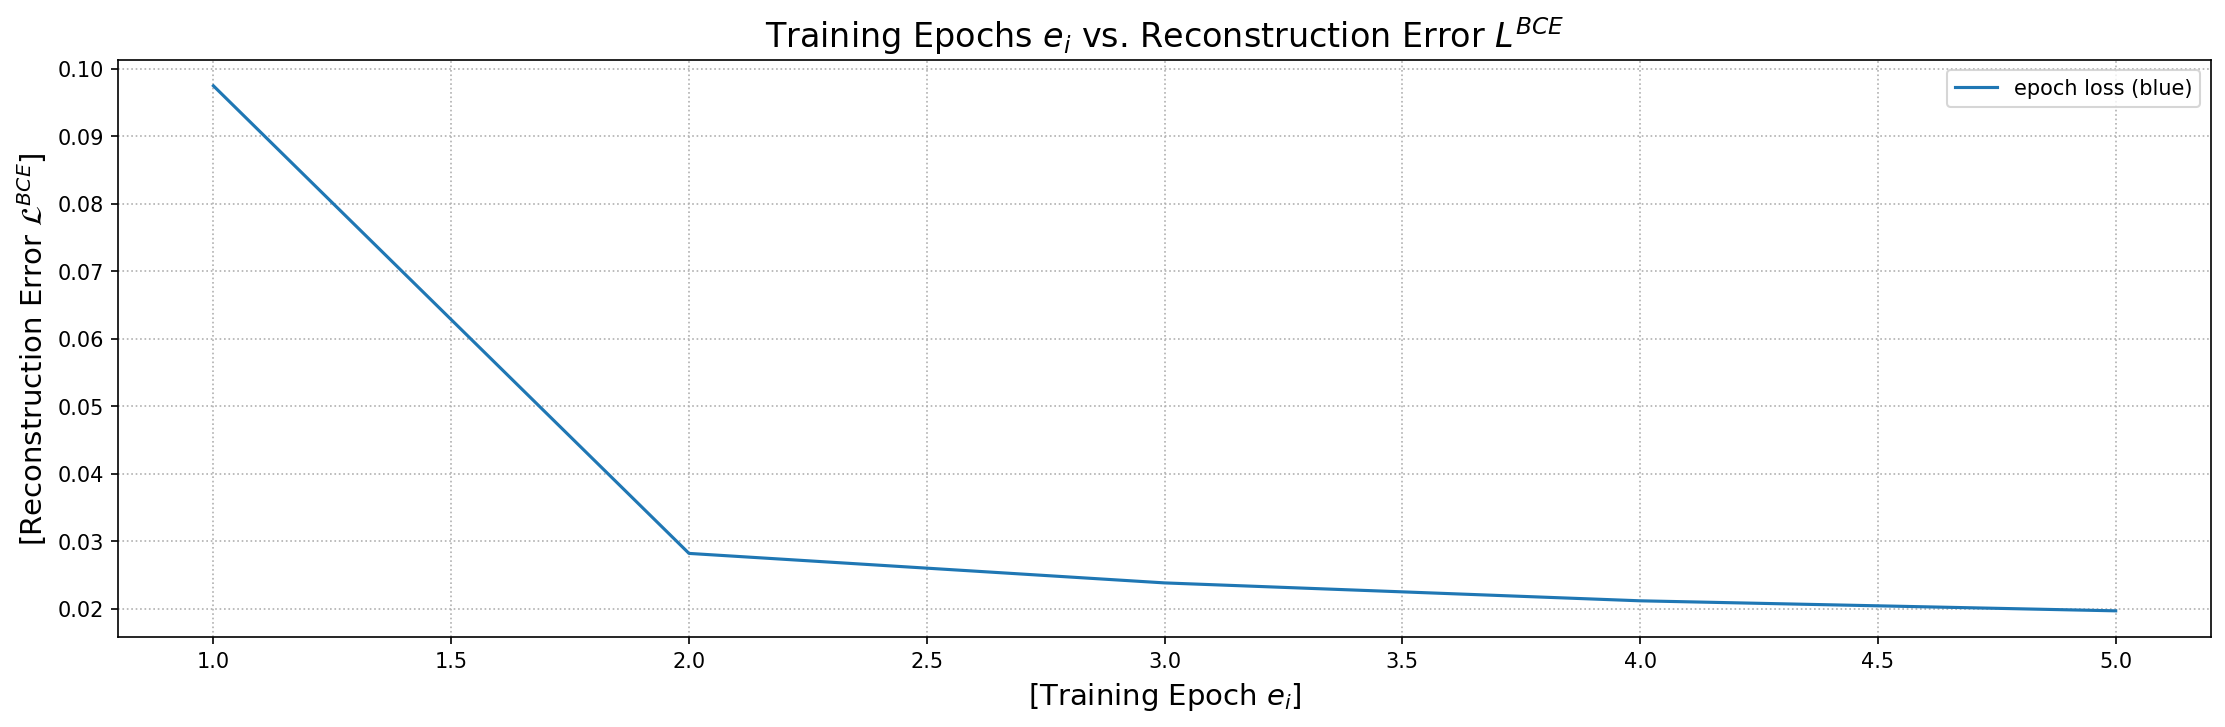

In [98]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figwidth(18)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' prediction error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel("[Training Epoch $e_i$]", fontsize=14)
ax.set_ylabel("[Reconstruction Error $\mathcal{L}^{BCE}$]", fontsize=14)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Reconstruction Error $L^{BCE}$', fontsize=16);

It can be observed that the reconstruction error of the AENN model begins to decrease continuously after five epochs. This observation implies that the model is gradually succeeding in reconstructing the journal entries contained within the dataset. However, the visualization also shows that the model could be trained for several more epochs until the reconstruction error no longer decreases or converges.

## 5. Autoencoder Neural Network Model Evaluation

In this section, we want to evaluate the learned AENN model's ability to detect anomalies in journal entry data. We will use pre-trained AENN models for this purpose. The evaluation includes the **local** as well as the **global** anomalies of the dataset.

### 5.1 Loading a Model Checkpoint

For the evaluation, we typically load the AENN model with the **lowest** reconstruction error or use another, i.e., already pre-trained, model. During training, we saved a checkpoint of the model parameters for each epoch within the local model directory. We will now load a model checkpoint that has already been trained for **30 training epochs**:

In [99]:
# restore pretrained model checkpoint
encoder_model_name = 'https://raw.githubusercontent.com/HSG-AIML-Teaching/ML2025-Lab/main/lab_8/03_models/ep_30_encoder_model_small.pth'
decoder_model_name = 'https://raw.githubusercontent.com/HSG-AIML-Teaching/ML2025-Lab/main/lab_8/03_models/ep_30_decoder_model_small.pth'

# read stored model from the remote location
encoder_bytes = urllib.request.urlopen(encoder_model_name)
decoder_bytes = urllib.request.urlopen(decoder_model_name)

# load tensor from io.BytesIO object
encoder_buffer = io.BytesIO(encoder_bytes.read())
decoder_buffer = io.BytesIO(decoder_bytes.read())

# init evaluation encoder and decoder model
encoder_eval = encoder()
decoder_eval = decoder()

# push encoder and decoder model to compute device
encoder_eval = encoder_train.to(device)
decoder_eval = decoder_train.to(device)

# load trained models
encoder_eval.load_state_dict(torch.load(encoder_buffer, map_location=lambda storage, loc: storage))
decoder_eval.load_state_dict(torch.load(decoder_buffer, map_location=lambda storage, loc: storage))

<All keys matched successfully>

### 5.2 Evaluation des Modells

After successfully loading the model checkpoint, we transfer the model for evaluation purposes to the `CPU` (Note: This allows us to calculate the reconstruction errors of all journal entries without any limitations due to the `GPU` memory):

In [100]:
# set networks in evaluation mode (don't apply dropout)
encoder_eval.eval()
decoder_eval.eval()

# push encoder and decoder model to compute device
encoder_eval = encoder_eval.to('cpu')
decoder_eval = decoder_eval.to('cpu')

# push the dataset to the CPU
torch_dataset = torch_dataset.to('cpu')

# push the loss function to the CPU
loss_function = loss_function.to('cpu')

In the next step, we calculate the **individual** BCE reconstruction errors for each journal entry $x_{i}$ within the dataset. First, the reconstruction $\hat{x}{i}$ of each entry is determined. Second, the BCE reconstruction error of the reconstructed entry $\hat{x}{i}$ is calculated by comparing it to the original journal entries $x_{i}$ from the dataset:"

In [101]:
# reconstruct encoded transactional data
reconstruction = decoder_eval(encoder_eval(torch_dataset))

# init binary cross entropy errors
reconstruction_loss_transaction = np.zeros(reconstruction.size()[0])

# iterate over all detailed reconstructions
for i in range(0, reconstruction.size()[0]):

    # determine reconstruction loss - individual transactions
    reconstruction_loss_transaction[i] = loss_function(reconstruction[i], torch_dataset[i]).item()

    if(i % 10000 == 0):

        ### print conversion summary
        now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
        print('[LOG {}] collected individual reconstruction loss of: {:05}/{:05} transactions'.format(now, i, reconstruction.size()[0]))

[LOG 2025.05.12-20:16:33] collected individual reconstruction loss of: 00000/91247 transactions
[LOG 2025.05.12-20:16:33] collected individual reconstruction loss of: 10000/91247 transactions
[LOG 2025.05.12-20:16:34] collected individual reconstruction loss of: 20000/91247 transactions
[LOG 2025.05.12-20:16:35] collected individual reconstruction loss of: 30000/91247 transactions
[LOG 2025.05.12-20:16:35] collected individual reconstruction loss of: 40000/91247 transactions
[LOG 2025.05.12-20:16:36] collected individual reconstruction loss of: 50000/91247 transactions
[LOG 2025.05.12-20:16:37] collected individual reconstruction loss of: 60000/91247 transactions
[LOG 2025.05.12-20:16:38] collected individual reconstruction loss of: 70000/91247 transactions
[LOG 2025.05.12-20:16:39] collected individual reconstruction loss of: 80000/91247 transactions
[LOG 2025.05.12-20:16:39] collected individual reconstruction loss of: 90000/91247 transactions


After calculating the individual reconstruction errors, we visualize the magnitude of each error:

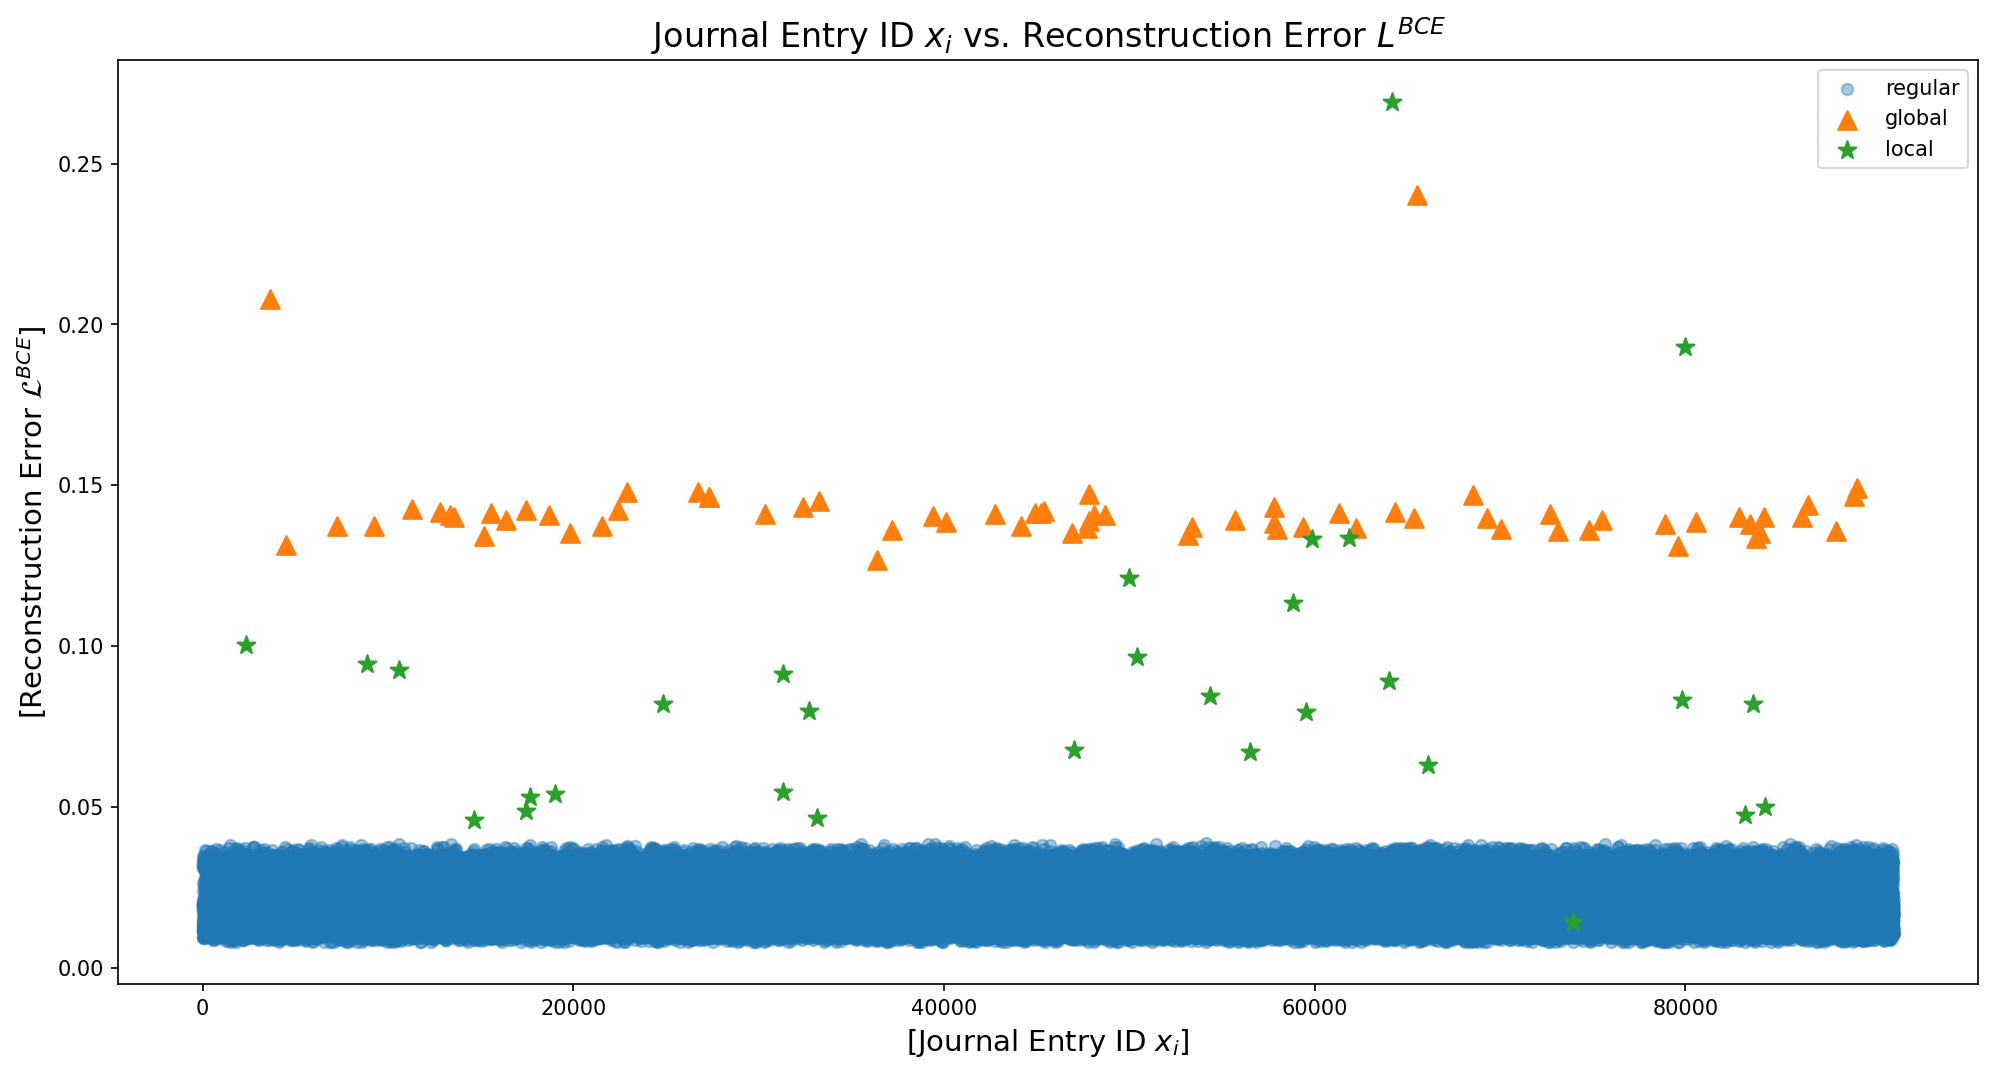

In [102]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# set plot size
fig.set_figwidth(16)
fig.set_figheight(8)

# assign unique id to transactions
plot_data = np.column_stack((np.arange(len(reconstruction_loss_transaction)), reconstruction_loss_transaction))

# obtain regular transactions as well as global and local anomalies
regular_data = plot_data[label == 'regular']
global_outliers = plot_data[label == 'global']
local_outliers = plot_data[label == 'local']

# plot reconstruction error scatter plot
ax.scatter(regular_data[:, 0], regular_data[:, 1], c='C0', alpha=0.4, marker="o", s=30, label='regular') # plot regular transactions
ax.scatter(global_outliers[:, 0], global_outliers[:, 1], c='C1', marker="^", s=80, label='global') # plot global outliers
ax.scatter(local_outliers[:, 0], local_outliers[:, 1], c='C2', marker="*", s=80, label='local') # plot local outliers

# add plot legend of transaction classes
ax.legend(loc='best')

# add axis legends
ax.set_xlabel("[Journal Entry ID $x_i$]", fontsize=14)
ax.set_ylabel("[Reconstruction Error $\mathcal{L}^{BCE}$]", fontsize=14)

# add plot title
plt.title('Journal Entry ID $x_i$ vs. Reconstruction Error $L^{BCE}$', fontsize=16);

The visualization shows that our AENN model can reconstruct most regular journal entries with low error. Simultaneously, both the **global anomalies** (green) and **local anomalies** (red) exhibit a comparatively high reconstruction error. Based on this analysis result, we can conclude that it is possible to differentiate **anomalies** (green and red) from regular journal entries (blue) within the dataset using reconstruction errors

To further investigate this observation, we will now filter out journal entries that have a **reconstruction error >= 0.12** from the dataset. Additionally, we assume (as demonstrated above) that these journal entries correspond to the **global anomalies** within the total population of journal entries.

In [103]:
# append labels to original dataset
ori_dataset['label'] = label

# extract transactions exhibiting a reconstruction error >= 0.12
autoencoder_global_anomalies = ori_dataset[reconstruction_loss_transaction >= 0.12]

# inspect transactions exhibiting a reconstruction error >= 0.12
autoencoder_global_anomalies

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
3643,532930,G92,W69,K78,J13,W62,S49,92445535.21,59585050.56,global
4483,532954,J38,C30,G28,T38,C62,L03,92445511.29,59585034.34,global
7244,532974,U94,K13,K84,U04,N56,N94,92445503.32,59585040.04,global
9230,532973,W25,G35,K00,C11,B38,C25,92445498.62,59585051.03,global
11307,532959,C89,S43,E40,Y34,L29,N28,92445526.13,59585044.24,global
...,...,...,...,...,...,...,...,...,...,...
86321,532963,Z06,G77,Z22,R09,V09,X53,92445528.45,59585039.25,global
86606,532929,E59,R76,D30,M02,D16,B35,92445514.34,59585044.67,global
88134,532932,R07,U18,V96,L28,K79,K77,92445516.58,59585038.80,global
89091,532966,H54,Q11,X82,H69,J21,R89,92445515.72,59585046.47,global


Let's now extract the journal entries into an Excel table to make them available to the audit team. First, we will generate a timestamp of the data extract for the audit trail of the audit:

In [104]:
timestamp = dt.datetime.utcnow().strftime("%Y-%m-%d_%H-%M-%S")

Next, we extract the filtered **global anomalies** as an Excel file for further substantive testing:

In [105]:
# specify the filename of the excel spreadsheet
filename = str(timestamp) + " - ACA_001_autoencoder_global_anomalies.xlsx"

# specify the target data directory of the excel spreadsheet
data_directory = os.path.join(results_directory, filename)

# extract the filtered transactions to excel
autoencoder_global_anomalies.to_excel(data_directory, header=True, index=False, sheet_name="Global_Anomalies")

Now, let's closely examine the journal entries with a **reconstruction error >= 0.04 but <= 0.12**. We assume (as illustrated above) that these journal entries correspond to the **local anomalies** within the population of journal entries:

In [106]:
# extract transactions exhibiting a reconstruction error < 0.12 and >= 0.04
autoencoder_local_anomalies = ori_dataset[(reconstruction_loss_transaction >= 0.04) & (reconstruction_loss_transaction < 0.12)]

# inspect transactions exhibiting a reconstruction error < 0.12 and >= 0.04
autoencoder_local_anomalies

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
2312,533007,C1,C11,C1,C78,A1,B1,910635.2878,54442.68859,local
8868,532983,C1,C11,C1,C72,A1,B1,910639.3765,54456.99952,local
10585,532994,C1,C11,C1,C76,A1,B1,910645.0762,54448.44020,local
14632,532992,C1,C11,C1,C57,A1,B1,910649.9255,54442.87996,local
17461,532996,C1,C11,C1,C93,A1,B1,910636.7098,54448.70394,local
17678,533008,C1,C11,C1,C90,A1,B1,910651.2760,54456.23481,local
19035,532991,C1,C11,C1,C91,A1,B1,910668.8875,54440.85658,local
24823,533009,C1,C11,C1,C32,A1,B1,910658.4585,54432.74266,local
31317,533002,C1,C11,C1,C60,A1,B1,910648.5451,54446.38283,local
31327,532985,C1,C11,C1,C75,A1,B1,910650.5090,54449.48313,local


Next, we'll again extract the filtered journal entries into an Excel table to make them available to the audit team. First, we will generate a timestamp of the data extract for the audit trail of the audit:

In [107]:
timestamp = dt.datetime.utcnow().strftime("%Y-%m-%d_%H-%M-%S")

Following that, we'll extract the filtered **local anomalies** as an Excel file for further substantive testing:

In [108]:
# specify the filename of the excel spreadsheet
filename = str(timestamp) + " - ACA_002_autoencoder_local_anomalies.xlsx"

# specify the target data directory of the excel spreadsheet
data_directory = os.path.join(results_directory, filename)

# extract the filtered transactions to excel
autoencoder_local_anomalies.to_excel(data_directory, header=True, index=False, sheet_name="Local_Anomalies")

## 6. Evaluation of Journal Entry Representations

In a real-world audit context, it's generally beneficial to examine the **learned representations** of the journal entries by the AENN model in addition to the reconstruction error. This examination allows for insights into the **structural semantics** of the entries and corresponding attributes. Furthermore, the analysis offers the possibility to contextualize any identified anomalies within the population of journal entries.

To obtain the representation of the journal entry, we perform a forward pass through the encoder of the AENN model for each journal entry. To do this, we load an encoder network **model checkpoint** trained for 80 epochs:

In [109]:
# restore pretrained model checkpoint
encoder_model_name = 'https://raw.githubusercontent.com/HSG-AIML-Teaching/ML2025-Lab/main/lab_8/03_models/ep_80_encoder_model_small.pth'

# read stored model from the remote location
encoder_bytes = urllib.request.urlopen(encoder_model_name)

# load tensor from io.BytesIO object
encoder_buffer = io.BytesIO(encoder_bytes.read())

# init evaluation encoder and decoder model
encoder_eval = encoder()

# push encoder and decoder model to compute device
encoder_eval = encoder_eval.to('cpu')

# load trained models
encoder_eval.load_state_dict(torch.load(encoder_buffer, map_location=lambda storage, loc: storage))

<All keys matched successfully>

Next, we perform a forward pass through the AENN model for each journal entry. Consequently, we obtain the three-dimensional representation of each entry:

In [110]:
# push the dataset to the CPU
torch_dataset = torch_dataset.to('cpu')

# run forward path through encoder to obtain journal entry representations
entry_representations = encoder_eval(torch_dataset)

# convert the representations to a pandas dataframe
entry_representation = pd.DataFrame(entry_representations.data.cpu().numpy(), columns=['z1', 'z2', 'z3'])

Subsequently, for validation and visualization purposes, we label the representations with the original labels:

In [111]:
entry_representation['label'] = label

Before visualizing, let's carefully examine the obtained coordinates:

In [112]:
entry_representation.head(10)

,z1,z2,z3,label
0,-6.409090,12.882844,95.381752,regular
1,-6.896410,24.001057,52.031860,regular
2,-7.684586,24.307302,70.182663,regular
3,-11.590373,42.750675,79.003227,regular
4,-7.081393,14.820823,102.584084,regular
5,-7.805017,24.851305,70.429100,regular
6,-5.836756,0.957955,141.852112,regular
7,-22.579536,88.615242,42.046707,regular
8,-15.027751,60.568302,66.610153,regular
9,-6.322841,23.694666,39.425270,regular


Due to the three-dimensional **latent space**, we can visualize the space and the representations using the `Matplotlib 3D` functionality. In the following cell, we create a visualization of this space and the representations:

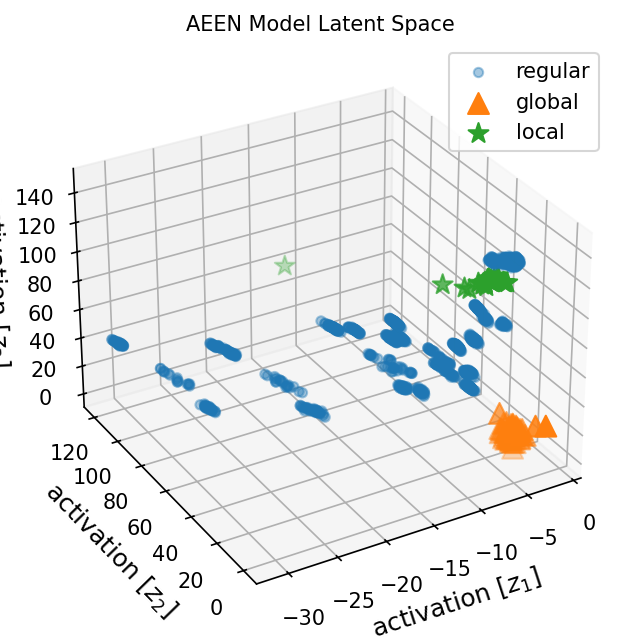

In [113]:
# enforce inline plotting
%matplotlib inline

# import 3d plotting and animation libraries
from IPython.display import HTML
from matplotlib import animation
from mpl_toolkits.mplot3d import axes3d

# init the plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

# change plot perspective
ax.view_init(elev=30, azim=240)

# set axis paramaters of subplot
ax.grid(linestyle='dotted')

# plot regular transactions, just the first 1000 to gain an intuition
regular = entry_representation[entry_representation['label'] == 'regular']
ax.scatter(regular['z1'][0:2000], regular['z2'][0:2000], regular['z3'][0:2000], c='C0', alpha=0.4, marker="o", label='regular')

# plot first order anomalous transactions
global_anomalies = entry_representation[entry_representation['label'] == 'global']
ax.scatter(global_anomalies['z1'], global_anomalies['z2'], global_anomalies['z3'], c='C1', s=100, marker="^", label='global')

# plot second order anomalous transactions
local_anomalies = entry_representation[entry_representation['label'] == 'local']
ax.scatter(local_anomalies['z1'], local_anomalies['z2'], local_anomalies['z3'], c='C2', s=100, marker="*", label='local')

# set axis labels
ax.set_xlabel('activation [$z_1$]', weight='normal', fontsize=12)
ax.set_ylabel('activation [$z_2$]', weight='normal', fontsize=12)
ax.set_zlabel('activation [$z_3$]', weight='normal', fontsize=12)

# add plot legend of transaction classes
ax.legend(loc='best')

# set plot title
plt.title('AEEN Model Latent Space', fontsize=10);

## Lab Aufgaben:

To deepen your understanding, we recommend working through the following exercises:

**1. Train and evaluate an Autoencoder Neural Network model with a reduced bottleneck.**

> The architecture presented within the notebook led to a good model for anomaly detection. Check how the performance changes when the dimensionality of the bottleneck layer is reduced. To do this, reduce the number of neurons within the encoder and decoder bottlenecks to two neurons. How does the model's ability to detect anomalies in the journal entry data change? Can different statements be made for global and local anomalies?

[LOG 2025.05.12-20:27:46] (Reduced Bottleneck) epoch: [1/5], epoch-train-loss: 0.09822975
[LOG 2025.05.12-20:27:46] epoch: [1/5], epoch-train-loss improved from inf to 0.09822974823477977, saving model checkpoint to "./03_models"
[LOG 2025.05.12-20:27:51] (Reduced Bottleneck) epoch: [2/5], epoch-train-loss: 0.03050096
[LOG 2025.05.12-20:27:51] epoch: [2/5], epoch-train-loss improved from 0.09822975 to 0.030500959602366155, saving model checkpoint to "./03_models"
[LOG 2025.05.12-20:27:56] (Reduced Bottleneck) epoch: [3/5], epoch-train-loss: 0.02904849
[LOG 2025.05.12-20:27:56] epoch: [3/5], epoch-train-loss improved from 0.03050096 to 0.029048487220121468, saving model checkpoint to "./03_models"
[LOG 2025.05.12-20:28:01] (Reduced Bottleneck) epoch: [4/5], epoch-train-loss: 0.02702871
[LOG 2025.05.12-20:28:01] epoch: [4/5], epoch-train-loss improved from 0.02904849 to 0.027028714177338473, saving model checkpoint to "./03_models"
[LOG 2025.05.12-20:28:06] (Reduced Bottleneck) epoch: [5

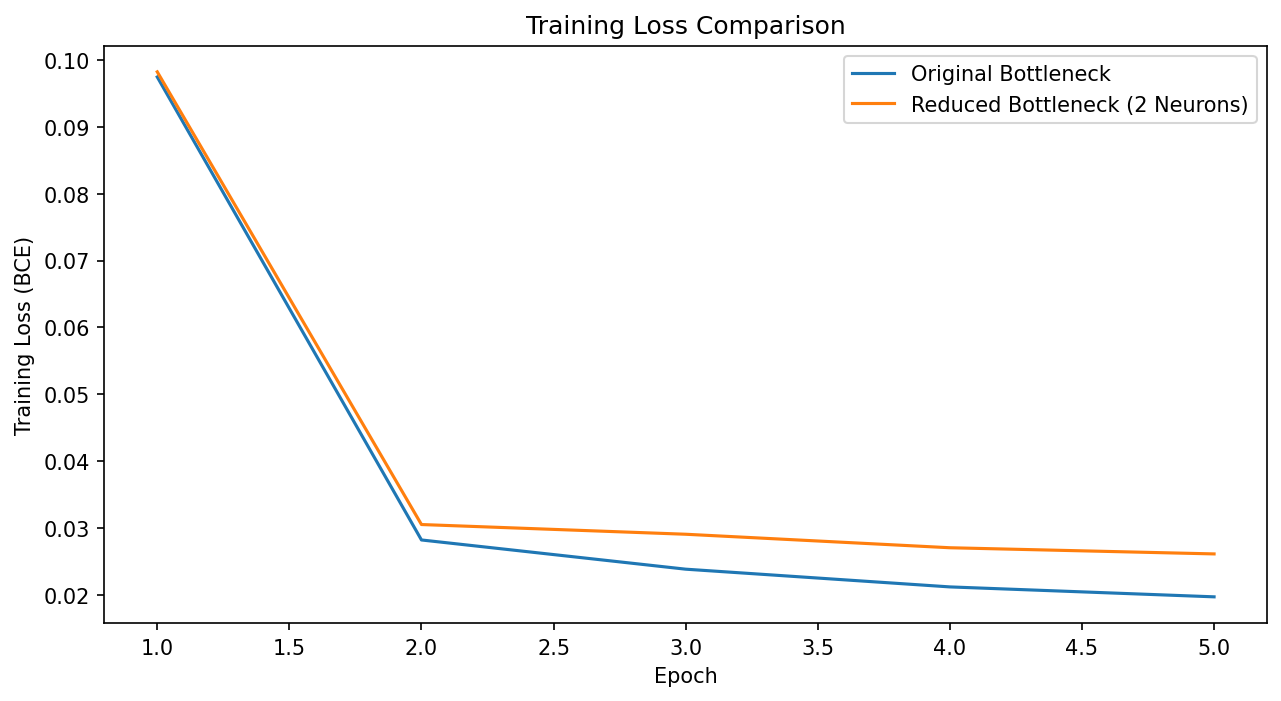


Reconstruction Error Distribution (Reduced Bottleneck):
           count      mean       std       min       25%       50%       75%  \
label                                                                          
global      70.0  0.108411  0.003315  0.096549  0.106466  0.109332  0.110469   
local       30.0  0.023658  0.003390  0.015557  0.020107  0.024564  0.026373   
regular  91147.0  0.025131  0.008119  0.010926  0.014538  0.028629  0.030812   

              max  
label              
global   0.112418  
local    0.027774  
regular  0.039515  


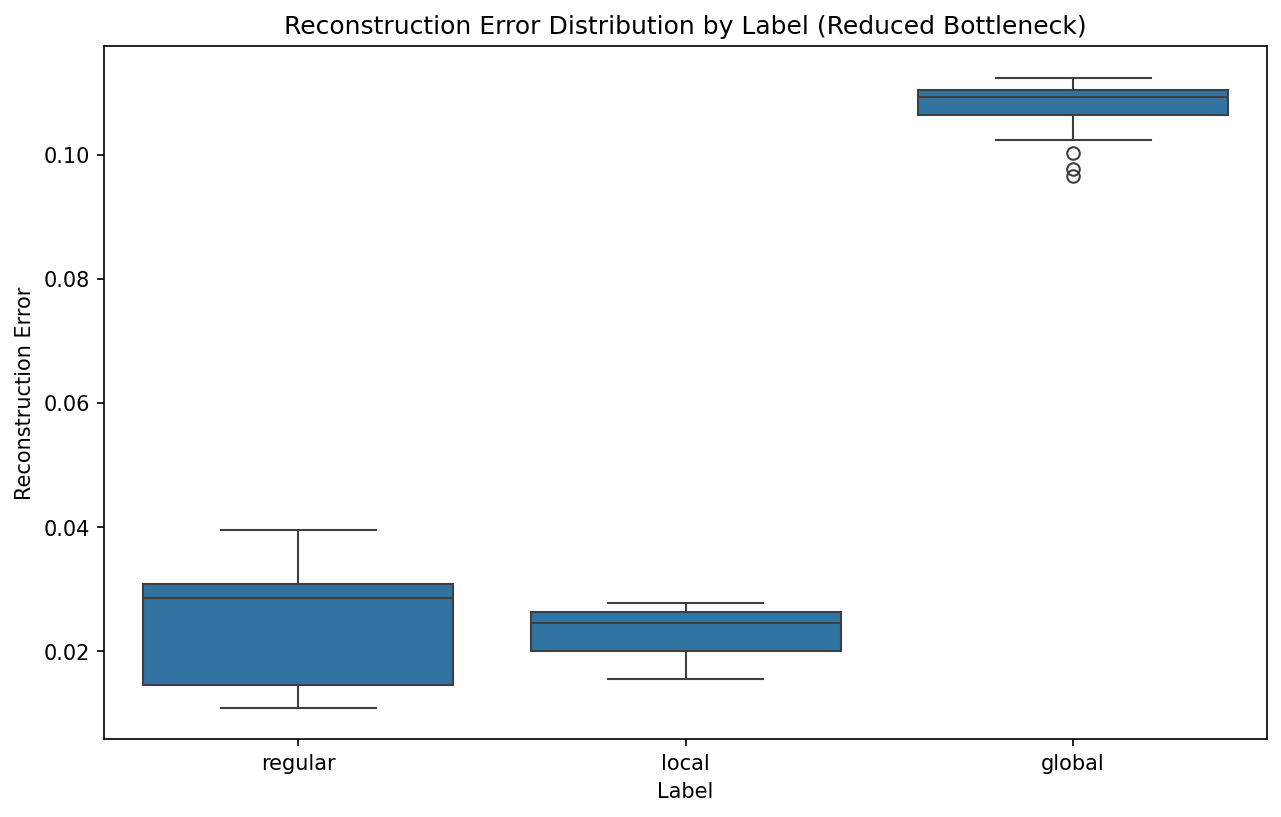

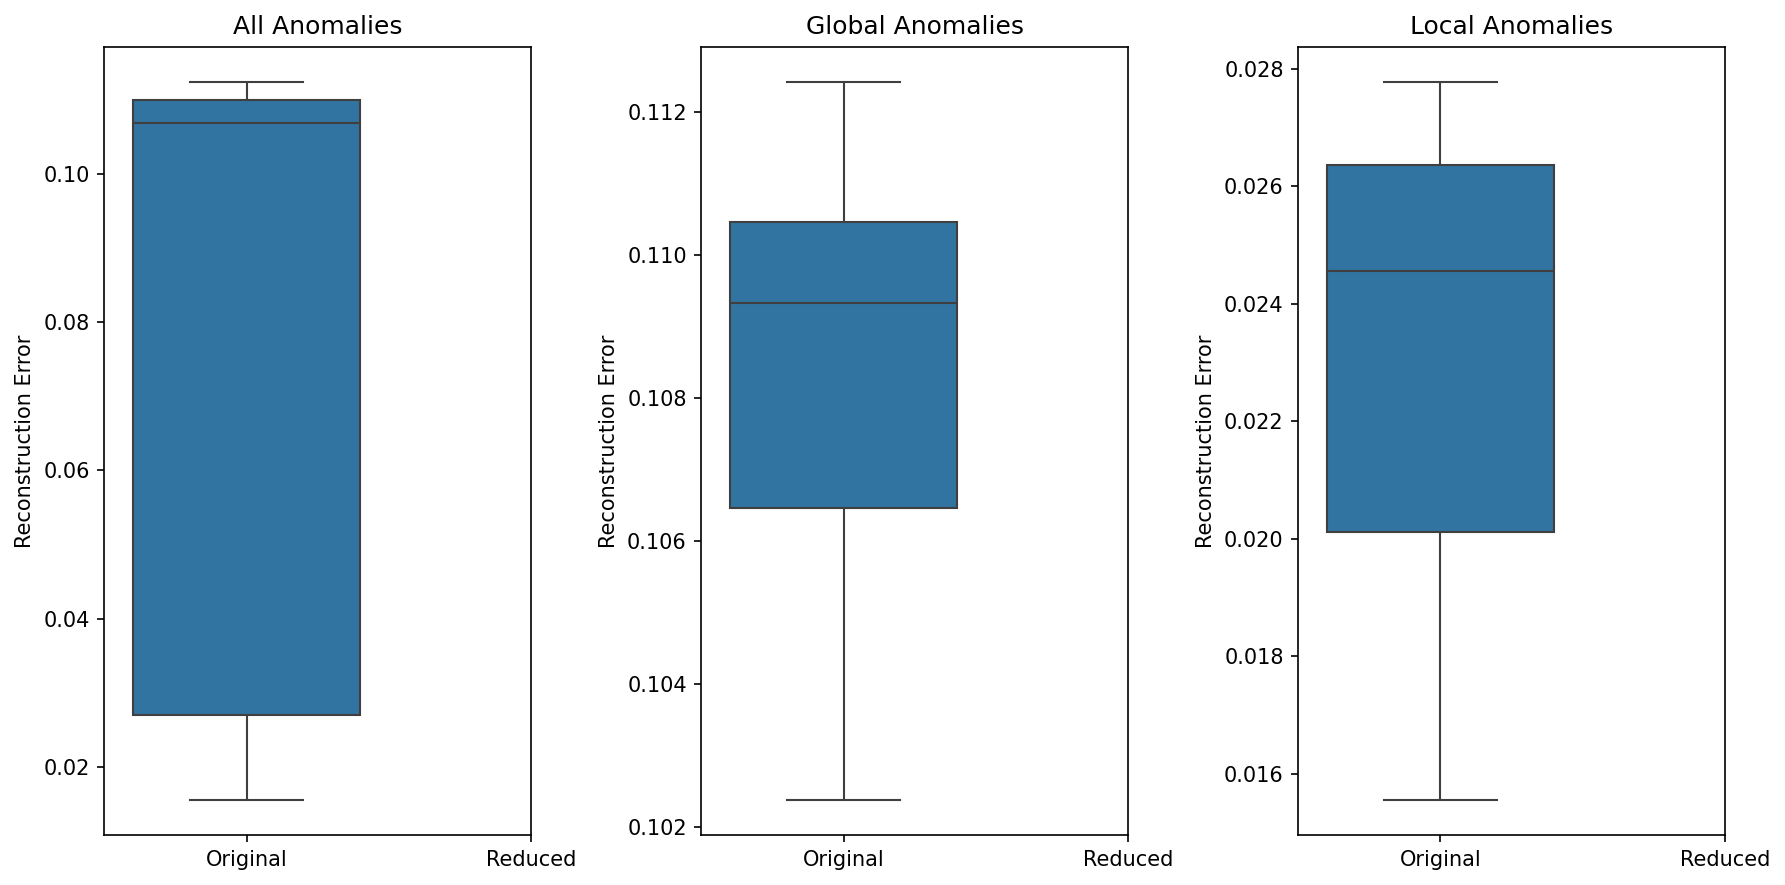

In [120]:
# ***************************************************
# You can insert you solution here.
# ***************************************************
# implementation of the modified encoder network with a bottleneck of 2 neurons
class encoder_reduced(nn.Module):

    # define class constructor
    def __init__(self):

        # call super class constructor
        super(encoder_reduced, self).__init__()

        # specify layer 1 - in 618, out 512
        self.encoder_L1 = nn.Linear(in_features=ori_subset_transformed.shape[1], out_features=512, bias=True) # add linearity
        nn.init.xavier_uniform_(self.encoder_L1.weight) # init weights
        self.encoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity

        # specify layer 2 - in 512, out 256
        self.encoder_L2 = nn.Linear(512, 256, bias=True)
        nn.init.xavier_uniform_(self.encoder_L2.weight)
        self.encoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 256, out 128
        self.encoder_L3 = nn.Linear(256, 128, bias=True)
        nn.init.xavier_uniform_(self.encoder_L3.weight)
        self.encoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 4 - in 128, out 64
        self.encoder_L4 = nn.Linear(128, 64, bias=True)
        nn.init.xavier_uniform_(self.encoder_L4.weight)
        self.encoder_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 5 - in 64, out 32
        self.encoder_L5 = nn.Linear(64, 32, bias=True)
        nn.init.xavier_uniform_(self.encoder_L5.weight)
        self.encoder_R5 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 6 - in 32, out 16
        self.encoder_L6 = nn.Linear(32, 16, bias=True)
        nn.init.xavier_uniform_(self.encoder_L6.weight)
        self.encoder_R6 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 7 - in 16, out 8
        self.encoder_L7 = nn.Linear(16, 8, bias=True)
        nn.init.xavier_uniform_(self.encoder_L7.weight)
        self.encoder_R7 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 8 - in 8, out 4
        self.encoder_L8 = nn.Linear(8, 4, bias=True)
        nn.init.xavier_uniform_(self.encoder_L8.weight)
        self.encoder_R8 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 9 - in 4, out 2 (reduced bottleneck)
        self.encoder_L9 = nn.Linear(4, 2, bias=True)
        nn.init.xavier_uniform_(self.encoder_L9.weight)
        self.encoder_R9 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

    # define forward pass
    def forward(self, x):

        # define forward pass through the network
        x = self.encoder_R1(self.encoder_L1(x))
        x = self.encoder_R2(self.encoder_L2(x))
        x = self.encoder_R3(self.encoder_L3(x))
        x = self.encoder_R4(self.encoder_L4(x))
        x = self.encoder_R5(self.encoder_L5(x))
        x = self.encoder_R6(self.encoder_L6(x))
        x = self.encoder_R7(self.encoder_L7(x))
        x = self.encoder_R8(self.encoder_L8(x))
        x = self.encoder_R9(self.encoder_L9(x))

        return x

# implementation of the modified decoder network with a bottleneck of 2 neurons
class decoder_reduced(nn.Module):

    # define class constructor
    def __init__(self):

        # call super class constructor
        super(decoder_reduced, self).__init__()

        # specify layer 1 - in 2, out 4 (reduced bottleneck)
        self.decoder_L1 = nn.Linear(in_features=2, out_features=4, bias=True) # add linearity
        nn.init.xavier_uniform_(self.decoder_L1.weight)  # init weights
        self.decoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity

        # specify layer 2 - in 4, out 8
        self.decoder_L2 = nn.Linear(4, 8, bias=True)
        nn.init.xavier_uniform_(self.decoder_L2.weight)
        self.decoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 8, out 16
        self.decoder_L3 = nn.Linear(8, 16, bias=True)
        nn.init.xavier_uniform_(self.decoder_L3.weight)
        self.decoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 4 - in 16, out 32
        self.decoder_L4 = nn.Linear(16, 32, bias=True)
        nn.init.xavier_uniform_(self.decoder_L4.weight)
        self.decoder_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 5 - in 32, out 64
        self.decoder_L5 = nn.Linear(32, 64, bias=True)
        nn.init.xavier_uniform_(self.decoder_L5.weight)
        self.decoder_R5 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 6 - in 64, out 128
        self.decoder_L6 = nn.Linear(64, 128, bias=True)
        nn.init.xavier_uniform_(self.decoder_L6.weight)
        self.decoder_R6 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 7 - in 128, out 256
        self.decoder_L7 = nn.Linear(128, 256, bias=True)
        nn.init.xavier_uniform_(self.decoder_L7.weight)
        self.decoder_R7 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 8 - in 256, out 512
        self.decoder_L8 = nn.Linear(256, 512, bias=True)
        nn.init.xavier_uniform_(self.decoder_L8.weight)
        self.decoder_R8 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 9 - in 512, out 618
        self.decoder_L9 = nn.Linear(in_features=512, out_features=ori_subset_transformed.shape[1], bias=True)
        nn.init.xavier_uniform_(self.decoder_L9.weight)
        self.decoder_R9 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

    # define forward pass
    def forward(self, x):

        # define forward pass through the network
        x = self.decoder_R1(self.decoder_L1(x))
        x = self.decoder_R2(self.decoder_L2(x))
        x = self.decoder_R3(self.decoder_L3(x))
        x = self.decoder_R4(self.decoder_L4(x))
        x = self.decoder_R5(self.decoder_L5(x))
        x = self.decoder_R6(self.decoder_L6(x))
        x = self.decoder_R7(self.decoder_L7(x))
        x = self.decoder_R8(self.decoder_L8(x))
        x = self.decoder_R9(self.decoder_L9(x))

        return x

# Instantiate the modified encoder and decoder models
encoder_reduced_train = encoder_reduced()
decoder_reduced_train = decoder_reduced()

# Push models to the device (GPU if available, otherwise CPU)
encoder_reduced_train = encoder_reduced_train.to(device)
decoder_reduced_train = decoder_reduced_train.to(device)

# Define the optimizer for the reduced models
encoder_reduced_optimizer = torch.optim.Adam(encoder_reduced_train.parameters(), lr=learning_rate)
decoder_reduced_optimizer = torch.optim.Adam(decoder_reduced_train.parameters(), lr=learning_rate)

# Re-initialize the training dataloader to ensure reproducibility
train_dataloader = dataloader.DataLoader(torch_dataset, batch_size=mini_batch_size, shuffle=True)

# init collection of training epoch losses for reduced model
train_epoch_losses_reduced = []

# set the model in training mode (apply dropout when needed)
encoder_reduced_train.train()
decoder_reduced_train.train()

# init the best loss by setting it to infinity for reduced model
best_loss_reduced = np.inf

# train autoencoder model with reduced bottleneck
for epoch in range(num_epochs):

    # init collection of epoch losses
    train_mini_batch_losses_reduced = []

    # init mini batch counter
    mini_batch_count = 0

    # iterate over all mini-batches
    for mini_batch_data in train_dataloader:

        # increase mini batch counter
        mini_batch_count += 1

        # push mini batch data to compute device
        mini_batch_data = mini_batch_data.to(device)

        # =================== (1) forward pass ===================================

        # run forward pass
        z_representation = encoder_reduced_train(mini_batch_data) # encode mini-batch data
        mini_batch_reconstruction = decoder_reduced_train(z_representation) # decode mini-batch data

        # =================== (2) compute reconstruction loss ====================

        # determine reconstruction loss
        reconstruction_loss = loss_function(mini_batch_reconstruction, mini_batch_data)

        # =================== (3) backward pass ==================================

        # reset graph gradients
        decoder_reduced_optimizer.zero_grad()
        encoder_reduced_optimizer.zero_grad()

        # run backward pass
        reconstruction_loss.backward()

        # =================== (4) update model parameters ========================

        # update network parameters
        decoder_reduced_optimizer.step()
        encoder_reduced_optimizer.step()

        # =================== monitor training progress ==========================

        # print training progress each 1.000 mini-batches
        if mini_batch_count % 1000 == 0:

            # print mini batch reconstuction results
            now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
            print('[LOG {}] (Reduced Bottleneck) epoch: [{}/{}], batch: {}, batch-train-loss: {}'.format(str(now), str(epoch+1), str(num_epochs), str(mini_batch_count), str(np.round(reconstruction_loss.item(), 8))))

        # collect mini-batch loss
        train_mini_batch_losses_reduced.extend([reconstruction_loss.item()])

    # =================== evaluate model performance =============================

    # determine mean min-batch loss of epoch
    train_epoch_loss_reduced = np.mean(train_mini_batch_losses_reduced)

    # print epoch reconstuction results
    now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
    print('[LOG {}] (Reduced Bottleneck) epoch: [{}/{}], epoch-train-loss: {}'.format(str(now), str(epoch+1), str(num_epochs), str(np.round(train_epoch_loss_reduced, 8))))

    # collect epoch loss
    train_epoch_losses_reduced.extend([train_epoch_loss_reduced])

    # =================== save model checkpoints ===============================

    # check if we have a new best model in terms of the lowest reconstruction error
    if train_epoch_loss_reduced < best_loss_reduced:

        # log to the console
        now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
        print('[LOG {}] epoch: [{}/{}], epoch-train-loss improved from {} to {}, saving model checkpoint to "{}"'.format(str(now), str(epoch+1), str(num_epochs), str(np.round(best_loss_reduced, 8)), str(train_epoch_loss_reduced), str(models_directory)))

        # update the best epoch training loss
        best_loss_reduced = train_epoch_loss_reduced

        # save the encoder and decoder model checkpoints
        torch.save(encoder_reduced_train.state_dict(), os.path.join(models_directory, 'encoder_reduced_model.pth'))
        torch.save(decoder_reduced_train.state_dict(), os.path.join(models_directory, 'decoder_reduced_model.pth'))

# Plot training loss
plt.figure()
plt.plot(range(1, num_epochs + 1), train_epoch_losses, label='Original Bottleneck')
plt.plot(range(1, num_epochs + 1), train_epoch_losses_reduced, label='Reduced Bottleneck (2 Neurons)')
plt.xlabel('Epoch')
plt.ylabel('Training Loss (BCE)')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()

# --- Evaluation ---

# Load the best reduced models
encoder_reduced_eval = encoder_reduced()
decoder_reduced_eval = decoder_reduced()

encoder_reduced_eval.load_state_dict(torch.load(os.path.join(models_directory, 'encoder_reduced_model.pth')))
decoder_reduced_eval.load_state_dict(torch.load(os.path.join(models_directory, 'decoder_reduced_model.pth')))

# Push models to the device
encoder_reduced_eval = encoder_reduced_eval.to(device)
decoder_reduced_eval = decoder_reduced_eval.to(device)

# Set models to evaluation mode
encoder_reduced_eval.eval()
decoder_reduced_eval.eval()

# Calculate reconstruction errors for the entire dataset using the reduced model
reconstruction_errors_reduced = []
with torch.no_grad():
    for data in torch_dataset:
        encoded_data = encoder_reduced_eval(data.unsqueeze(0).to(device))
        decoded_data = decoder_reduced_eval(encoded_data)
        loss = loss_function(decoded_data, data.unsqueeze(0).to(device))
        reconstruction_errors_reduced.append(loss.item())

# Add reconstruction errors to the original dataset for analysis
ori_dataset['reconstruction_error_reduced'] = reconstruction_errors_reduced

# Analyze reconstruction errors for different labels with the reduced model
error_distribution_reduced = ori_dataset.groupby('label')['reconstruction_error_reduced'].describe()
print("\nReconstruction Error Distribution (Reduced Bottleneck):")
print(error_distribution_reduced)

# Visualize reconstruction errors for different labels with the reduced model
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='reconstruction_error_reduced', data=ori_dataset)
plt.title('Reconstruction Error Distribution by Label (Reduced Bottleneck)')
plt.xlabel('Label')
plt.ylabel('Reconstruction Error')
plt.show()

# Compare reconstruction errors between the original and reduced models for anomalies
#anomalies_original = ori_dataset[ori_dataset['label'] != 'regular']['reconstruction_error'].values
anomalies_reduced = ori_dataset[ori_dataset['label'] != 'regular']['reconstruction_error_reduced'].values

#global_anomalies_original = ori_dataset[ori_dataset['label'] == 'global']['reconstruction_error'].values
global_anomalies_reduced = ori_dataset[ori_dataset['label'] == 'global']['reconstruction_error_reduced'].values

#local_anomalies_original = ori_dataset[ori_dataset['label'] == 'local']['reconstruction_error'].values
local_anomalies_reduced = ori_dataset[ori_dataset['label'] == 'local']['reconstruction_error_reduced'].values

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
#sns.boxplot(data=[anomalies_original, anomalies_reduced], showfliers=False)
sns.boxplot(data=[anomalies_reduced], showfliers=False)
plt.xticks([0, 1], ['Original', 'Reduced'])
plt.title('All Anomalies')
plt.ylabel('Reconstruction Error')

plt.subplot(1, 3, 2)
#sns.boxplot(data=[global_anomalies_original, global_anomalies_reduced], showfliers=False)
sns.boxplot(data=[global_anomalies_reduced], showfliers=False)
plt.xticks([0, 1], ['Original', 'Reduced'])
plt.title('Global Anomalies')
plt.ylabel('Reconstruction Error')

plt.subplot(1, 3, 3)
#sns.boxplot(data=[local_anomalies_original, local_anomalies_reduced], showfliers=False)
sns.boxplot(data=[local_anomalies_reduced], showfliers=False)
plt.xticks([0, 1], ['Original', 'Reduced'])
plt.title('Local Anomalies')
plt.ylabel('Reconstruction Error')

plt.tight_layout()
plt.show()

**2. Train and evaluate a shallow Autoencoder Neural Network model.**

> The architecture presented within the notebook led to a good model for anomaly detection. Check how the performance changes when several hidden layers are removed. To do this, adjust the implementations of the encoder and decoder accordingly. How does the model's ability to detect anomalies in the journal entry data change? Can different statements be made for global and local anomalies?

[LOG 2025.05.12-20:30:06] (Shallow) epoch: [1/5], epoch-train-loss: 0.24199938
[LOG 2025.05.12-20:30:06] epoch: [1/5], epoch-train-loss improved from inf to 0.24199938396877527, saving model checkpoint to "./03_models"
[LOG 2025.05.12-20:30:10] (Shallow) epoch: [2/5], epoch-train-loss: 0.03180159
[LOG 2025.05.12-20:30:10] epoch: [2/5], epoch-train-loss improved from 0.24199938 to 0.031801590581031366, saving model checkpoint to "./03_models"
[LOG 2025.05.12-20:30:13] (Shallow) epoch: [3/5], epoch-train-loss: 0.03100144
[LOG 2025.05.12-20:30:13] epoch: [3/5], epoch-train-loss improved from 0.03180159 to 0.031001438960161318, saving model checkpoint to "./03_models"
[LOG 2025.05.12-20:30:16] (Shallow) epoch: [4/5], epoch-train-loss: 0.03074059
[LOG 2025.05.12-20:30:16] epoch: [4/5], epoch-train-loss improved from 0.03100144 to 0.03074058640596743, saving model checkpoint to "./03_models"
[LOG 2025.05.12-20:30:20] (Shallow) epoch: [5/5], epoch-train-loss: 0.03059808
[LOG 2025.05.12-20:30:

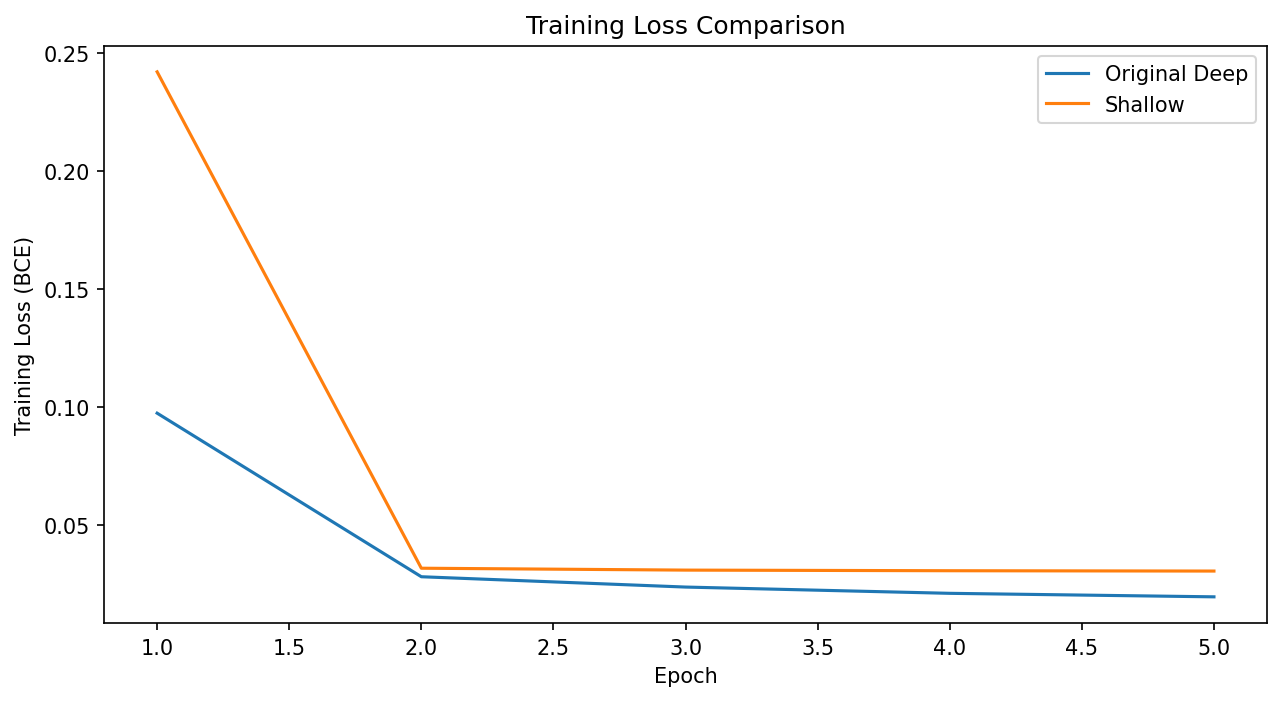


Reconstruction Error Distribution (Shallow):
           count      mean       std       min       25%       50%       75%  \
label                                                                          
global      70.0  0.092723  0.003253  0.080102  0.091384  0.093068  0.094029   
local       30.0  0.023895  0.001269  0.019828  0.024171  0.024301  0.024395   
regular  91147.0  0.030487  0.008357  0.018237  0.019834  0.032374  0.034672   

              max  
label              
global   0.099936  
local    0.024632  
regular  0.046704  


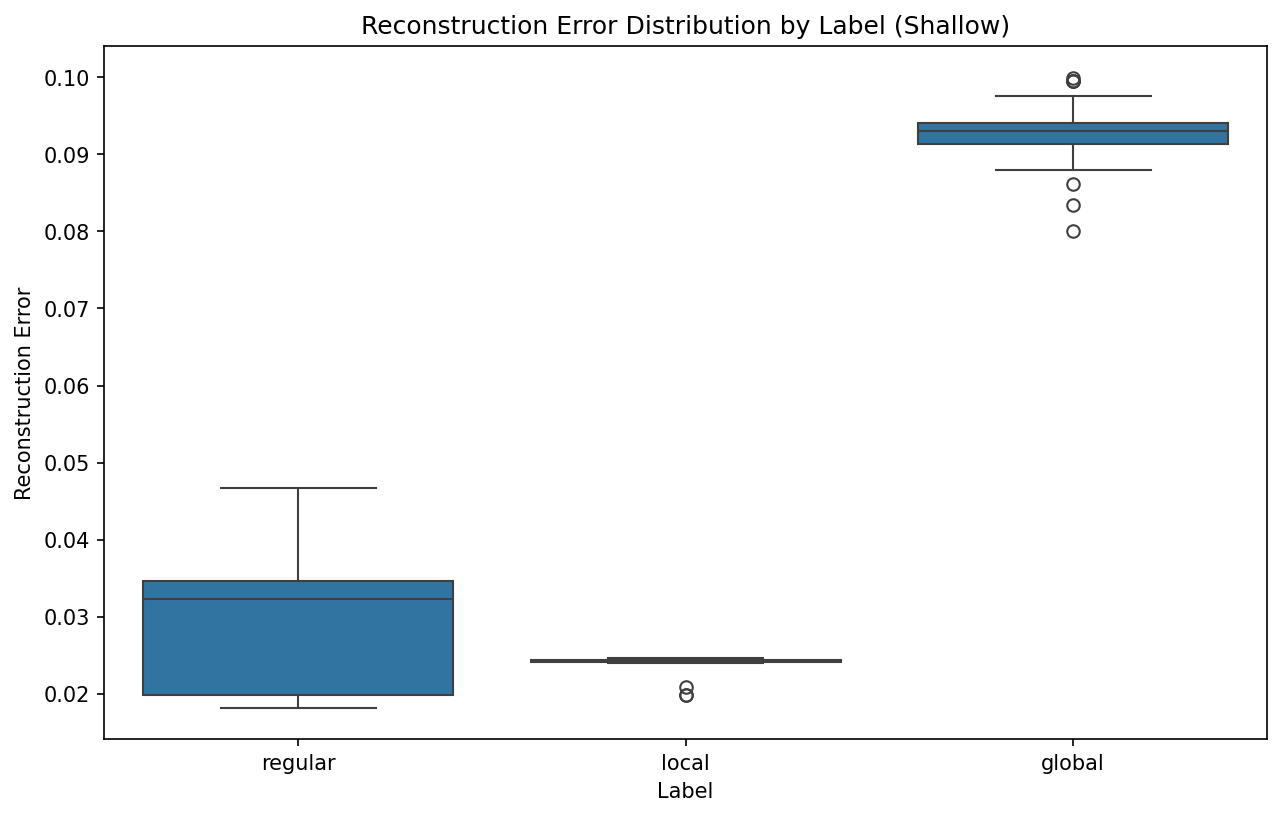

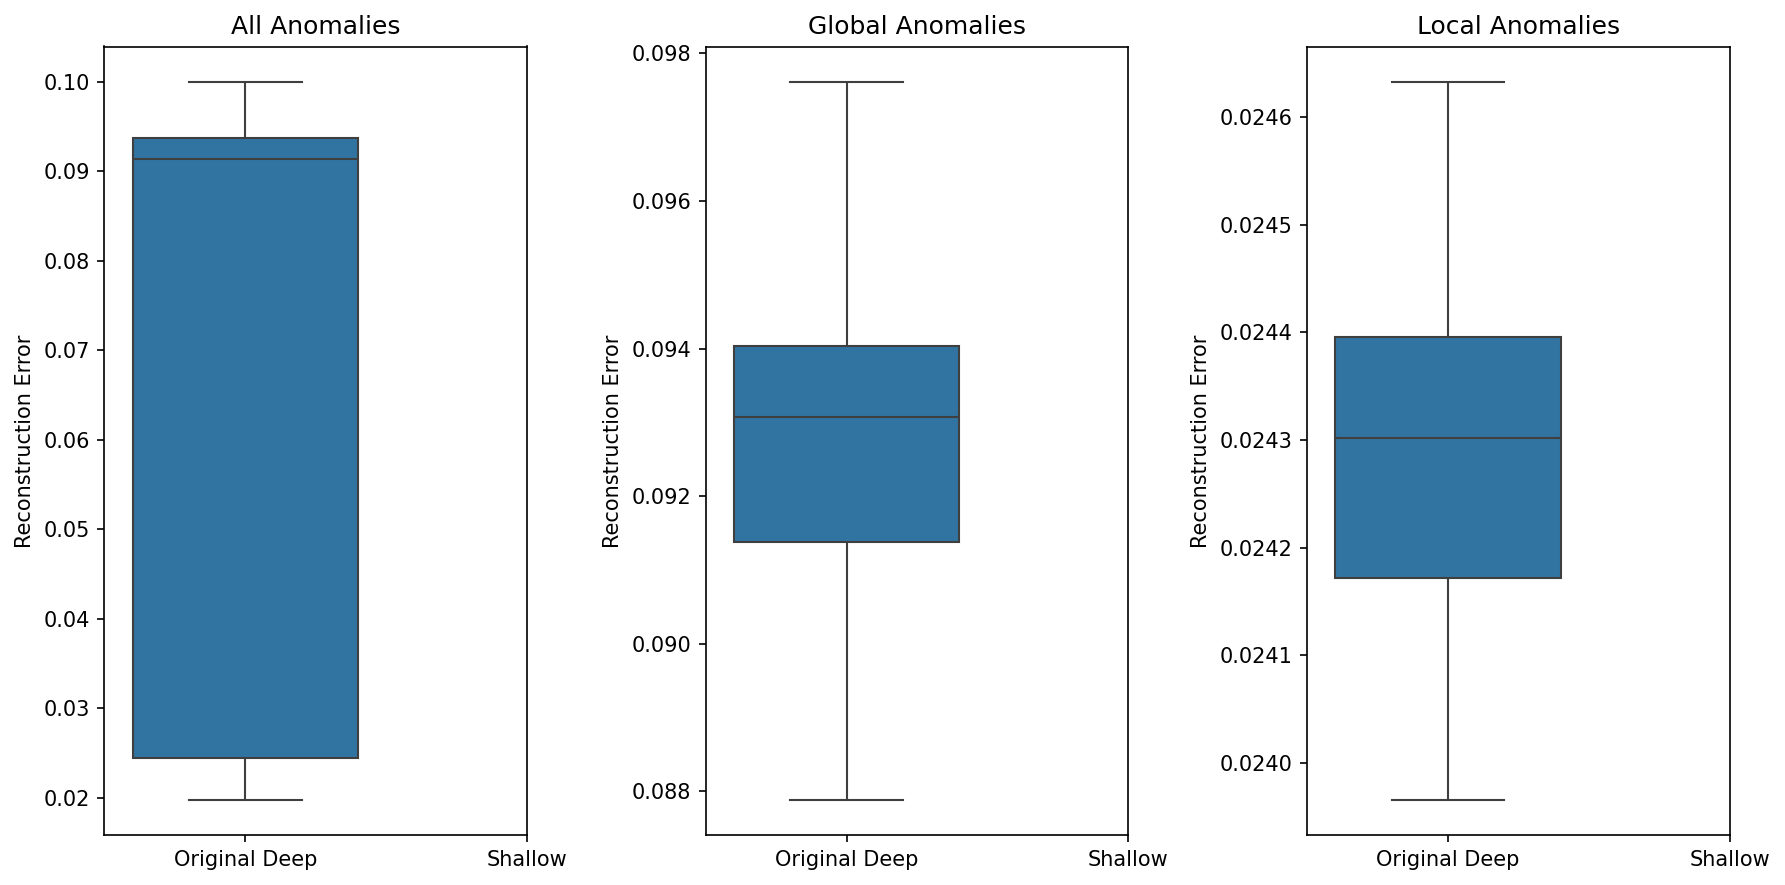

In [121]:
# ***************************************************
# You can insert you solution here.
# ***************************************************
# implementation of the shallow encoder network
class encoder_shallow(nn.Module):

    # define class constructor
    def __init__(self):

        # call super class constructor
        super(encoder_shallow, self).__init__()

        # specify layer 1 - in 618, out 64
        self.encoder_L1 = nn.Linear(in_features=ori_subset_transformed.shape[1], out_features=64, bias=True) # add linearity
        nn.init.xavier_uniform_(self.encoder_L1.weight) # init weights
        self.encoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity

        # specify layer 2 - in 64, out 32
        self.encoder_L2 = nn.Linear(64, 32, bias=True)
        nn.init.xavier_uniform_(self.encoder_L2.weight)
        self.encoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 32, out 3 (bottleneck)
        self.encoder_L3 = nn.Linear(32, 3, bias=True)
        nn.init.xavier_uniform_(self.encoder_L3.weight)
        self.encoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)


    # define forward pass
    def forward(self, x):

        # define forward pass through the network
        x = self.encoder_R1(self.encoder_L1(x))
        x = self.encoder_R2(self.encoder_L2(x))
        x = self.encoder_R3(self.encoder_L3(x))

        return x

# implementation of the shallow decoder network
class decoder_shallow(nn.Module):

    # define class constructor
    def __init__(self):

        # call super class constructor
        super(decoder_shallow, self).__init__()

        # specify layer 1 - in 3, out 32 (bottleneck)
        self.decoder_L1 = nn.Linear(in_features=3, out_features=32, bias=True) # add linearity
        nn.init.xavier_uniform_(self.decoder_L1.weight)  # init weights
        self.decoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity

        # specify layer 2 - in 32, out 64
        self.decoder_L2 = nn.Linear(32, 64, bias=True)
        nn.init.xavier_uniform_(self.decoder_L2.weight)
        self.decoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 64, out 618
        self.decoder_L3 = nn.Linear(in_features=64, out_features=ori_subset_transformed.shape[1], bias=True)
        nn.init.xavier_uniform_(self.decoder_L3.weight)
        self.decoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

    # define forward pass
    def forward(self, x):

        # define forward pass through the network
        x = self.decoder_R1(self.decoder_L1(x))
        x = self.decoder_R2(self.decoder_L2(x))
        x = self.decoder_R3(self.decoder_L3(x))

        return x

# Instantiate the shallow encoder and decoder models
encoder_shallow_train = encoder_shallow()
decoder_shallow_train = decoder_shallow()

# Push models to the device (GPU if available, otherwise CPU)
encoder_shallow_train = encoder_shallow_train.to(device)
decoder_shallow_train = decoder_shallow_train.to(device)

# Define the optimizer for the shallow models
encoder_shallow_optimizer = torch.optim.Adam(encoder_shallow_train.parameters(), lr=learning_rate)
decoder_shallow_optimizer = torch.optim.Adam(decoder_shallow_train.parameters(), lr=learning_rate)

# Re-initialize the training dataloader to ensure reproducibility
train_dataloader = dataloader.DataLoader(torch_dataset, batch_size=mini_batch_size, shuffle=True)

# init collection of training epoch losses for shallow model
train_epoch_losses_shallow = []

# set the model in training mode (apply dropout when needed)
encoder_shallow_train.train()
decoder_shallow_train.train()

# init the best loss by setting it to infinity for shallow model
best_loss_shallow = np.inf

# train shallow autoencoder model
for epoch in range(num_epochs):

    # init collection of epoch losses
    train_mini_batch_losses_shallow = []

    # init mini batch counter
    mini_batch_count = 0

    # iterate over all mini-batches
    for mini_batch_data in train_dataloader:

        # increase mini batch counter
        mini_batch_count += 1

        # push mini batch data to compute device
        mini_batch_data = mini_batch_data.to(device)

        # =================== (1) forward pass ===================================

        # run forward pass
        z_representation = encoder_shallow_train(mini_batch_data) # encode mini-batch data
        mini_batch_reconstruction = decoder_shallow_train(z_representation) # decode mini-batch data

        # =================== (2) compute reconstruction loss ====================

        # determine reconstruction loss
        reconstruction_loss = loss_function(mini_batch_reconstruction, mini_batch_data)

        # =================== (3) backward pass ==================================

        # reset graph gradients
        decoder_shallow_optimizer.zero_grad()
        encoder_shallow_optimizer.zero_grad()

        # run backward pass
        reconstruction_loss.backward()

        # =================== (4) update model parameters ========================

        # update network parameters
        decoder_shallow_optimizer.step()
        encoder_shallow_optimizer.step()

        # =================== monitor training progress ==========================

        # print training progress each 1.000 mini-batches
        if mini_batch_count % 1000 == 0:

            # print mini batch reconstuction results
            now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
            print('[LOG {}] (Shallow) epoch: [{}/{}], batch: {}, batch-train-loss: {}'.format(str(now), str(epoch+1), str(num_epochs), str(mini_batch_count), str(np.round(reconstruction_loss.item(), 8))))

        # collect mini-batch loss
        train_mini_batch_losses_shallow.extend([reconstruction_loss.item()])

    # =================== evaluate model performance =============================

    # determine mean min-batch loss of epoch
    train_epoch_loss_shallow = np.mean(train_mini_batch_losses_shallow)

    # print epoch reconstuction results
    now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
    print('[LOG {}] (Shallow) epoch: [{}/{}], epoch-train-loss: {}'.format(str(now), str(epoch+1), str(num_epochs), str(np.round(train_epoch_loss_shallow, 8))))

    # collect epoch loss
    train_epoch_losses_shallow.extend([train_epoch_loss_shallow])

    # =================== save model checkpoints ===============================

    # check if we have a new best model in terms of the lowest reconstruction error
    if train_epoch_loss_shallow < best_loss_shallow:

        # log to the console
        now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
        print('[LOG {}] epoch: [{}/{}], epoch-train-loss improved from {} to {}, saving model checkpoint to "{}"'.format(str(now), str(epoch+1), str(num_epochs), str(np.round(best_loss_shallow, 8)), str(train_epoch_loss_shallow), str(models_directory)))

        # update the best epoch training loss
        best_loss_shallow = train_epoch_loss_shallow

        # save the encoder and decoder model checkpoints
        torch.save(encoder_shallow_train.state_dict(), os.path.join(models_directory, 'encoder_shallow_model.pth'))
        torch.save(decoder_shallow_train.state_dict(), os.path.join(models_directory, 'decoder_shallow_model.pth'))

# Plot training loss
plt.figure()
plt.plot(range(1, num_epochs + 1), train_epoch_losses, label='Original Deep')
plt.plot(range(1, num_epochs + 1), train_epoch_losses_shallow, label='Shallow')
plt.xlabel('Epoch')
plt.ylabel('Training Loss (BCE)')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()

# --- Evaluation ---

# Load the best shallow models
encoder_shallow_eval = encoder_shallow()
decoder_shallow_eval = decoder_shallow()

encoder_shallow_eval.load_state_dict(torch.load(os.path.join(models_directory, 'encoder_shallow_model.pth')))
decoder_shallow_eval.load_state_dict(torch.load(os.path.join(models_directory, 'decoder_shallow_model.pth')))

# Push models to the device
encoder_shallow_eval = encoder_shallow_eval.to(device)
decoder_shallow_eval = decoder_shallow_eval.to(device)

# Set models to evaluation mode
encoder_shallow_eval.eval()
decoder_shallow_eval.eval()

# Calculate reconstruction errors for the entire dataset using the shallow model
reconstruction_errors_shallow = []
with torch.no_grad():
    for data in torch_dataset:
        encoded_data = encoder_shallow_eval(data.unsqueeze(0).to(device))
        decoded_data = decoder_shallow_eval(encoded_data)
        loss = loss_function(decoded_data, data.unsqueeze(0).to(device))
        reconstruction_errors_shallow.append(loss.item())

# Add reconstruction errors to the original dataset for analysis
ori_dataset['reconstruction_error_shallow'] = reconstruction_errors_shallow

# Analyze reconstruction errors for different labels with the shallow model
error_distribution_shallow = ori_dataset.groupby('label')['reconstruction_error_shallow'].describe()
print("\nReconstruction Error Distribution (Shallow):")
print(error_distribution_shallow)

# Visualize reconstruction errors for different labels with the shallow model
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='reconstruction_error_shallow', data=ori_dataset)
plt.title('Reconstruction Error Distribution by Label (Shallow)')
plt.xlabel('Label')
plt.ylabel('Reconstruction Error')
plt.show()

# Compare reconstruction errors between the original deep and shallow models for anomalies
#anomalies_original = ori_dataset[ori_dataset['label'] != 'regular']['reconstruction_error'].values
anomalies_shallow = ori_dataset[ori_dataset['label'] != 'regular']['reconstruction_error_shallow'].values

#global_anomalies_original = ori_dataset[ori_dataset['label'] == 'global']['reconstruction_error'].values
global_anomalies_shallow = ori_dataset[ori_dataset['label'] == 'global']['reconstruction_error_shallow'].values

#local_anomalies_original = ori_dataset[ori_dataset['label'] == 'local']['reconstruction_error'].values
local_anomalies_shallow = ori_dataset[ori_dataset['label'] == 'local']['reconstruction_error_shallow'].values

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
#sns.boxplot(data=[anomalies_original, anomalies_shallow], showfliers=False)
sns.boxplot(data=[anomalies_shallow], showfliers=False)
plt.xticks([0, 1], ['Original Deep', 'Shallow'])
plt.title('All Anomalies')
plt.ylabel('Reconstruction Error')

plt.subplot(1, 3, 2)
#sns.boxplot(data=[global_anomalies_original, global_anomalies_shallow], showfliers=False)
sns.boxplot(data=[global_anomalies_shallow], showfliers=False)
plt.xticks([0, 1], ['Original Deep', 'Shallow'])
plt.title('Global Anomalies')
plt.ylabel('Reconstruction Error')

plt.subplot(1, 3, 3)
#sns.boxplot(data=[local_anomalies_original, local_anomalies_shallow], showfliers=False)
sns.boxplot(data=[local_anomalies_shallow], showfliers=False)
plt.xticks([0, 1], ['Original Deep', 'Shallow'])
plt.title('Local Anomalies')
plt.ylabel('Reconstruction Error')

plt.tight_layout()
plt.show()

## Lab Summary

This notebook provided a step-by-step introduction to the **design, implementation, training, and evaluation** of a neural network-based approach to anomaly detection in accounting data. The code examples and exercises presented can serve as a starting point for the development and testing of more complex strategies for anomaly detection.